In [1]:
import os, time, joblib, numpy as np, pandas as pd

from tqdm import tqdm
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict



In [2]:
DATA_DIR = r"D:\CAPSTONE DESIGN\Model2\dataset" 
MODEL_DIR = "models/hybrid_snortml"
os.makedirs(MODEL_DIR, exist_ok=True)
FEAT_SELECTOR_PATH = os.path.join(MODEL_DIR, "feat_selector.joblib")
IMPUTER_PATH = os.path.join(MODEL_DIR, "imputer_median.joblib")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler_pt_log1p_std.joblib")
SELECTED_ORDER_PATH = os.path.join(MODEL_DIR, "selected_cols_order.joblib")

MAX_FILES_TO_TRY = 200
READ_CHUNKSIZE = 200_000
MAX_ROWS_FS = 100_000     
K_TARGET = 100            
VAR_THRESH_FS = 1e-4
CORR_THRESHOLD = 0.95    
RANDOM_STATE = 42


In [3]:
# helper functions
def find_csv_files(directory, max_files=200):
    csvs=[]
    for root, dirs, files in os.walk(directory):
        for f in files:
            if f.lower().endswith('.csv'):
                csvs.append(os.path.join(root, f))
                if len(csvs) >= max_files:
                    return csvs
    return csvs

def read_and_concat_with_source(paths, chunksize=200000, max_rows=None):
    collected=[]; total=0; ref_cols=None
    for p in tqdm(paths, desc="Reading CSVs"):
        basename = os.path.basename(p)
        try:
            for chunk in pd.read_csv(p, chunksize=chunksize, iterator=True, low_memory=True):
                if ref_cols is None:
                    ref_cols = chunk.columns.tolist()
                else:
                    common = [c for c in chunk.columns if c in ref_cols]
                    chunk = chunk[common]
                chunk = chunk.copy()
                chunk['source_file'] = basename
                collected.append(chunk)
                total += len(chunk)
                if max_rows and total >= max_rows:
                    return pd.concat(collected, ignore_index=True)
        except UnicodeDecodeError:
            for chunk in pd.read_csv(p, chunksize=chunksize, iterator=True, encoding='latin1', low_memory=True):
                if ref_cols is None:
                    ref_cols = chunk.columns.tolist()
                else:
                    common = [c for c in chunk.columns if c in ref_cols]
                    chunk = chunk[common]
                chunk = chunk.copy()
                chunk['source_file'] = basename
                collected.append(chunk)
                total += len(chunk)
                if max_rows and total >= max_rows:
                    return pd.concat(collected, ignore_index=True)
        except Exception as e:
            print("Skip file:", p, type(e).__name__)
            continue
    if not collected:
        raise RuntimeError("No data read.")
    return pd.concat(collected, ignore_index=True)

def normalize_cols(cols):
    out = []
    for c in cols:
        if not isinstance(c, str):
            out.append(c)
        else:
            s = c.strip().replace(' ', '_').replace('-', '_').replace('/', '_')
            out.append(s)
    return out

# load data
csv_paths = find_csv_files(DATA_DIR, MAX_FILES_TO_TRY)
if not csv_paths:
    raise FileNotFoundError("No CSV files found under DATA_DIR")
print("Found CSV files:", len(csv_paths))

df = read_and_concat_with_source(csv_paths, chunksize=READ_CHUNKSIZE, max_rows=None)
df.columns = normalize_cols(df.columns)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
print("Combined shape:", df.shape)

#deteksi kolom label
def detect_label_column(df):
    candidates = ["Label","label","Class","class","Attack","attack_type","Category"]
    for c in candidates:
        if c in df.columns:
            return c
    for c in df.columns:
        if df[c].dtype == object and df[c].nunique() <= 50:
            return c
    for c in df.columns:
        if pd.api.types.is_integer_dtype(df[c]) and df[c].nunique() <= 50:
            return c
    return None

label_col = detect_label_column(df)
if label_col is None:
    raise RuntimeError("Label column not found. Set FORCE_LABEL_COL or ensure dataset has labels.")
print("Detected label column:", label_col)

Found CSV files: 8


Reading CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

Reading CSVs: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Combined shape: (2574264, 80)
Detected label column: Label


In [4]:
# drop entirely empty or constant columns

const_cols = [c for c in df.columns if df[c].nunique(dropna=True) <= 1]
if const_cols:
    print(f"Dropping {len(const_cols)} constant columns.")
    df.drop(columns=const_cols, inplace=True)

Dropping 8 constant columns.


In [5]:
# robust_preprocess_selected.py
import os, joblib, numpy as np, pandas as pd
from sklearn.feature_selection import VarianceThreshold

MODEL_DIR = "models/hybrid_snortml"
os.makedirs(MODEL_DIR, exist_ok=True)
FEAT_SELECTOR_PATH = os.path.join(MODEL_DIR, "feat_selector.joblib")
OUT_INTERIM = os.path.join(MODEL_DIR, "df_selected_clean_tmp.joblib")

# --- ensure df exists ---
if 'df' not in globals():
    raise RuntimeError("DataFrame 'df' not found in workspace. Load your dataset into variable `df` first.")

# --- load selected cols if available, otherwise fallback to numeric columns]
if os.path.exists(FEAT_SELECTOR_PATH):
    print("Found feat_selector.joblib -> loading selected_cols.")
    fs = joblib.load(FEAT_SELECTOR_PATH)
    # support different storage shapes
    if isinstance(fs, dict):
        selected_cols = fs.get('feat_meta', fs).get('selected_cols', fs.get('selected_cols'))
    else:
        # try common attributes
        selected_cols = getattr(fs, 'selected_cols', None) or getattr(fs, 'features', None) or None
    if selected_cols is None:
        print("Warning: feat_selector.joblib did not contain 'selected_cols' key -> falling back to numeric columns.")
        selected_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
else:
    print("feat_selector.joblib not found -> falling back to numeric columns in df.")
    selected_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    # optionally run a quick VarianceThreshold to drop constant cols
    if len(selected_cols) > 0:
        tmp = df[selected_cols].copy()
        tmp = tmp.replace([np.inf, -np.inf], np.nan)
        tmp = tmp.fillna(tmp.median().fillna(0.0))
        vt = VarianceThreshold(threshold=1e-12)
        try:
            vt.fit(tmp)
            kept = [c for c, keep in zip(selected_cols, vt.get_support()) if keep]
            print(f"VarianceThreshold kept {len(kept)}/{len(selected_cols)} numeric cols.")
            selected_cols = kept
        except Exception:
            print("VarianceThreshold failed or skipped; using raw numeric columns.")

print("Selected count (final):", len(selected_cols))

# --- subset df to selected cols and safe copy ---
df_sel = df.loc[:, selected_cols].copy()
# replace infinities with NaN
df_sel.replace([np.inf, -np.inf], np.nan, inplace=True)

# compute quantiles for clipping
# Prefer computing quantiles on TRAIN only. If you have y_train/index for train, use that:
if 'y_train' in globals() and isinstance(y_train, (pd.Series, list, np.ndarray)) and len(y_train) == df.shape[0]:
    try:
        mask_train = np.ones(len(df), dtype=bool)  
    except Exception:
        mask_train = np.ones(len(df), dtype=bool)
else:
    mask_train = np.ones(len(df), dtype=bool)

# compute quantiles robustly (skip NaNs)
q_low, q_high = 0.001, 0.999   
try:
    q_l = df_sel.loc[mask_train].quantile(q_low)
    q_h = df_sel.loc[mask_train].quantile(q_high)
except Exception:
    q_l = df_sel.quantile(q_low)
    q_h = df_sel.quantile(q_high)

print("Computed quantile clipping bounds (per-column).")

# clip (broadcast per-column)
df_clipped = df_sel.clip(lower=q_l, upper=q_h, axis=1)

# choose log1p columns: non-negative AND max large-ish 
max_vals = df_clipped.max(numeric_only=True)
nonneg_mask = (df_clipped.min(numeric_only=True) >= 0)
large_mask = (max_vals > 1e3)
log_cols = [c for c in df_clipped.columns if c in large_mask.index and large_mask[c] and nonneg_mask[c]]
print(f"Will apply log1p to {len(log_cols)} columns (sample):", log_cols[:10])

# apply log1p safely (preserve NaN)
for c in log_cols:
    if df_clipped[c].notna().sum() == 0:
        continue
    df_clipped[c] = np.log1p(df_clipped[c].astype('float64'))

# replace remaining inf (should be none) and impute with column median 
df_clean_tmp = df_clipped.replace([np.inf, -np.inf], np.nan)
med = df_clean_tmp.median().fillna(0.0)
df_imputed_tmp = df_clean_tmp.fillna(med)

df_imputed_tmp = df_imputed_tmp.astype(np.float32, copy=False)

# diagnostics (top problematic columns) 
diag = []
for c in selected_cols:
    s_orig = df[c] if c in df.columns else pd.Series(dtype=object)
    s_num = pd.to_numeric(df_imputed_tmp[c], errors='coerce') if c in df_imputed_tmp.columns else pd.Series(dtype=float)
    diag.append({
        "col": c,
        "dtype": str(s_orig.dtype) if not s_orig.empty else "NA",
        "n_missing_original": int(s_orig.isna().sum()) if not s_orig.empty else None,
        "n_missing_after_replace": int(s_num.isna().sum()) if c in df_imputed_tmp.columns else None,
        "pct_missing_orig": float(s_orig.isna().mean()) if not s_orig.empty else None,
        "n_unique_orig": int(s_orig.nunique(dropna=True)) if not s_orig.empty else None,
        "min_after": float(s_num.min()) if not s_num.empty else np.nan,
        "max_after": float(s_num.max()) if not s_num.empty else np.nan,
        "mean_after": float(s_num.mean()) if not s_num.empty else np.nan,
        "variance_after": float(s_num.var()) if not s_num.empty else np.nan
    })
diag_df = pd.DataFrame(diag).sort_values("n_missing_original", ascending=False)
print("Diagnostics (top 20):")
display(diag_df.head(20))

joblib.dump({"df_selected_clean_tmp": df_imputed_tmp}, OUT_INTERIM, compress=3)
print("Saved interim cleaned selected dataframe to", OUT_INTERIM)



feat_selector.joblib not found -> falling back to numeric columns in df.
VarianceThreshold kept 70/70 numeric cols.
Selected count (final): 70
Computed quantile clipping bounds (per-column).
Will apply log1p to 48 columns (sample): ['Destination_Port', 'Flow_Duration', 'Total_Length_of_Fwd_Packets', 'Total_Length_of_Bwd_Packets', 'Fwd_Packet_Length_Max', 'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean', 'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Max', 'Bwd_Packet_Length_Mean']
Diagnostics (top 20):


col    dtype  n_missing_original  \
14            Flow_Bytes_s  float64                 359   
0         Destination_Port    int64                   0   
53     Fwd_Header_Length.1    int64                   0   
51    Avg_Fwd_Segment_Size  float64                   0   
50     Average_Packet_Size  float64                   0   
49           Down_Up_Ratio    int64                   0   
48          ECE_Flag_Count    int64                   0   
47          CWE_Flag_Count    int64                   0   
46          URG_Flag_Count    int64                   0   
45          ACK_Flag_Count    int64                   0   
44          PSH_Flag_Count    int64                   0   
43          RST_Flag_Count    int64                   0   
42          SYN_Flag_Count    int64                   0   
41          FIN_Flag_Count    int64                   0   
40  Packet_Length_Variance  float64                   0   
39       Packet_Length_Std  float64                   0   
38      Packet_Length_Mean  float64                   0   
52    Avg_Bwd_Segment_Size  float64                   0   
54     Subflow_Fwd_Packets    int64                   0   
36       Min_Packet_Length    int64                   0   

    n_missing_after_replace  pct_missing_orig  n_unique_orig  min_after  \
14                        0          0.000139        1593908   0.000000   
0                         0          0.000000          53805   2.890372   
53                        0          0.000000           3771   3.044523   
51                        0          0.000000          99716   0.000000   
50                        0          0.000000         212207   0.000000   
49                        0          0.000000             31   0.000000   
48                        0          0.000000              2   0.000000   
47                        0          0.000000              2   0.000000   
46                        0          0.000000              2   0.000000   
45                        0          0.000000              2   0.000000   
44                        0          0.000000              2   0.000000   
43                        0          0.000000              2   0.000000   
42                        0          0.000000              2   0.000000   
41                        0          0.000000              2   0.000000   
40                        0          0.000000         405565   0.000000   
39                        0          0.000000         412246   0.000000   
38                        0          0.000000         215826   0.000000   
52                        0          0.000000         147611   0.000000   
54                        0          0.000000           1432   1.000000   
36                        0          0.000000            215   0.000000   

     max_after  mean_after  variance_after  
14   19.450300    7.875494       21.331232  
0    11.082819    5.808725        6.086571  
53    8.943376    4.348230        0.992833  
51    7.750356    3.061542        2.499233  
50    7.444917    3.949211        4.093344  
49    6.000000    0.702427        0.441326  
48    0.000000    0.000000        0.000000  
47    0.000000    0.000000        0.000000  
46    1.000000    0.100525        0.090419  
45    1.000000    0.310249        0.213995  
44    1.000000    0.291524        0.206538  
43    0.000000    0.000000        0.000000  
42    1.000000    0.048107        0.045793  
41    1.000000    0.031600        0.030602  
40   16.636890    6.839959       25.698158  
39    8.318385    3.455013        6.331358  
38    7.282847    3.771133        4.105171  
52    7.973414    3.788759        6.290196  
54  293.000000    5.861275      233.918701  
36  233.000000   17.040112      525.371826

Saved interim cleaned selected dataframe to models/hybrid_snortml\df_selected_clean_tmp.joblib


In [6]:
PREPARED_PATH = os.path.join(MODEL_DIR, "prepared_for_ae.joblib")
IMPUTER_PATH = os.path.join(MODEL_DIR, "imputer_median.joblib")
PT_PATH = os.path.join(MODEL_DIR, "power_transformer.joblib")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler_std.joblib")
FEAT_SELECTOR_PATH = os.path.join(MODEL_DIR, "feat_selector.joblib")

RND_SEED = 42
TEST_SIZE = 0.15
VAL_SIZE = 0.15
VAR_THRESH = 1e-8        
K_TARGET = 100           
MI_SUBSAMPLE = 100_000   
CORR_THRESHOLD = 0.95    

# load interim df
tmp_path = os.path.join(MODEL_DIR, "df_selected_clean_tmp.joblib")
if not os.path.exists(tmp_path):
    raise RuntimeError(f"Interim cleaned DF not found: {tmp_path}. Run previous cleaning block first.")
d = joblib.load(tmp_path)
df_imputed_tmp = d.get('df_selected_clean_tmp', None)
if df_imputed_tmp is None:
    df_imputed_tmp = d if isinstance(d, pd.DataFrame) else None

if df_imputed_tmp is None:
    raise RuntimeError("Could not load df_imputed_tmp from joblib. Check saved object structure.")

# ensure df_imputed_tmp columns align with sel 
if 'sel' in globals():
    sel_cols = sel
else:
    if os.path.exists(FEAT_SELECTOR_PATH):
        fs = joblib.load(FEAT_SELECTOR_PATH)
        sel_cols = fs.get('feat_meta', fs).get('selected_cols', fs.get('selected_cols', list(df_imputed_tmp.columns)))
    else:
        sel_cols = list(df_imputed_tmp.columns)

# keep only columns present
sel_cols = [c for c in sel_cols if c in df_imputed_tmp.columns]
X_all = df_imputed_tmp[sel_cols].copy()
print("Using feature columns count:", len(sel_cols))

# detect label column from earlier df 
if 'label_col' in globals() and label_col in df.columns:
    label_col_name = label_col
else:
    if 'df' in globals() and 'label_col' in globals():
        label_col_name = label_col
    else:
        # fallback: find object dtype column with <=50 uniques
        cand = [c for c in df.columns if df[c].dtype == object and df[c].nunique() <= 200]
        if cand:
            label_col_name = cand[0]
        else:
            raise RuntimeError("Label column not found. Ensure label_col exists in globals or df.")

y_all = df[label_col_name].astype(str).reset_index(drop=True)
print("Using label column:", label_col_name, "unique labels:", y_all.nunique())

Using feature columns count: 70
Using label column: Label unique labels: 15


In [7]:
# 70/15/15 split (train/val/test) 
label_counts = y_all.value_counts()
if (label_counts >= 2).all():
    stratify_first = y_all
else:
    stratify_first = (~y_all.str.upper().eq("BENIGN")).astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size= (VAL_SIZE+TEST_SIZE), random_state=RND_SEED, stratify=stratify_first
)

# split temp equally into val/test
label_counts_temp = y_temp.value_counts()
if (label_counts_temp >= 2).all():
    stratify_second = y_temp
else:
    stratify_second = (~y_temp.str.upper().eq("BENIGN")).astype(int)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RND_SEED, stratify=stratify_second
)

print("Split sizes -> train:", X_train.shape[0], "val:", X_val.shape[0], "test:", X_test.shape[0])

# Imputer fit on train only 
imputer = SimpleImputer(strategy="median", copy=True)
imputer.fit(X_train)

Xtr_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
Xv_imp = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
Xte_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

joblib.dump(imputer, IMPUTER_PATH)
print("Saved imputer to", IMPUTER_PATH)


Split sizes -> train: 1801984 val: 386140 test: 386140
Saved imputer to models/hybrid_snortml\imputer_median.joblib


In [8]:
# VarianceThreshold (train-only) to remove constant/near-constant
vt = VarianceThreshold(threshold=VAR_THRESH)
vt.fit(Xtr_imp)
keep_mask = vt.get_support()
kept_cols_vt = [c for c,k in zip(Xtr_imp.columns, keep_mask) if k]
print("VarianceThreshold kept:", len(kept_cols_vt), "dropped:", Xtr_imp.shape[1]-len(kept_cols_vt))

Xtr_vt = Xtr_imp[kept_cols_vt].copy()
Xv_vt = Xv_imp[kept_cols_vt].copy()
Xte_vt = Xte_imp[kept_cols_vt].copy()

VarianceThreshold kept: 66 dropped: 4


In [9]:
# Feature selection via mutual_info_classif (label-aware) 
mi_k = min(K_TARGET * 3, Xtr_vt.shape[1])  # number of candidates to score
subsample_n = min(MI_SUBSAMPLE, max(1, Xtr_vt.shape[0]))

rng = np.random.default_rng(RND_SEED)

# if subsample equals full size, use all positions deterministically
if subsample_n == Xtr_vt.shape[0]:
    idx_sub = np.arange(Xtr_vt.shape[0])
else:
    idx_sub = rng.choice(Xtr_vt.shape[0], subsample_n, replace=False)

y_train_pos = y_train.reset_index(drop=True)

X_mi = Xtr_vt.reset_index(drop=True).iloc[idx_sub]   
y_train_sub = y_train_pos.iloc[idx_sub]              

# create binary labels for MI (BENIGN -> 0, others -> 1)
y_mi_binary = (~y_train_sub.astype(str).str.upper().eq("BENIGN")).astype(int).values

X_mi_arr = X_mi.values.astype(float)

# compute mutual information (SelectKBest expects shape [n_samples, n_features])
from sklearn.feature_selection import SelectKBest, mutual_info_classif
k_for_mi = min(mi_k, X_mi_arr.shape[1])
selector_mi = SelectKBest(mutual_info_classif, k=k_for_mi)

if np.unique(y_mi_binary).size == 1:
    print("Warning: y_mi_binary is constant in subsample — skipping MI selection fallback to variance ranking.")
    var_scores = Xtr_vt.var(axis=0).sort_values(ascending=False)
    top_cols_by_mi = list(var_scores.index[:max(K_TARGET*2, k_for_mi)])
else:
    selector_mi.fit(X_mi_arr, y_mi_binary)
    mi_scores = selector_mi.scores_
    if mi_scores is None:
        print("Warning: MI returned None scores; falling back to univariate rankings by variance.")
        var_scores = Xtr_vt.var(axis=0).sort_values(ascending=False)
        top_cols_by_mi = list(var_scores.index[:max(K_TARGET*2, k_for_mi)])
    else:
        col_scores = list(zip(X_mi.columns, mi_scores))
        col_scores_sorted = sorted(col_scores, key=lambda x: (-(0 if np.isnan(x[1]) else x[1]), x[0]))
        top_cols_by_mi = [c for c, s in col_scores_sorted[:max(K_TARGET*2, k_for_mi)]]

print("Top MI candidates:", len(top_cols_by_mi))


Top MI candidates: 66


In [10]:
# Correlation pruning among top candidates
cand = top_cols_by_mi

corr_mat = Xtr_vt[cand].corr().abs()
to_keep = []
to_drop = set()
for i,c in enumerate(cand):
    if c in to_drop:
        continue
    to_keep.append(c)
    # drop others highly correlated with c
    high = corr_mat.loc[c, cand].loc[lambda s: s > CORR_THRESHOLD].index.tolist()
    for h in high:
        if h != c:
            to_drop.add(h)

final_candidates = [c for c in to_keep if c in top_cols_by_mi]
final_selected = final_candidates[:min(len(final_candidates), K_TARGET)]

# fallback if not enough features selected
if len(final_selected) < K_TARGET:
    for c,s in col_scores_sorted:
        if c not in final_selected:
            final_selected.append(c)
        if len(final_selected) >= K_TARGET:
            break

Xtr_sel = Xtr_vt[final_selected].copy()
Xv_sel = Xv_vt[final_selected].copy()
Xte_sel = Xte_vt[final_selected].copy()

In [13]:
# Power transform (fit on train only) + StandardScaler 
# Use Yeo-Johnson because values may be negative; for strictly non-negative big columns you may have applied log1p earlier.
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(Xtr_sel)   
Xtr_pt = pd.DataFrame(pt.transform(Xtr_sel), columns=Xtr_sel.columns, index=Xtr_sel.index)
Xv_pt = pd.DataFrame(pt.transform(Xv_sel), columns=Xv_sel.columns, index=Xv_sel.index)
Xte_pt = pd.DataFrame(pt.transform(Xte_sel), columns=Xte_sel.columns, index=Xte_sel.index)

scaler = StandardScaler()
scaler.fit(Xtr_pt)
Xtr_scaled = scaler.transform(Xtr_pt).astype(np.float32)
Xv_scaled = scaler.transform(Xv_pt).astype(np.float32)
Xte_scaled = scaler.transform(Xte_pt).astype(np.float32)

In [14]:
# prepare AE benign subset (from y_train)
y_train_ser = y_train.reset_index(drop=True).astype(str).str.upper()
if (y_train_ser == "BENIGN").any():
    Xtr_benign = Xtr_scaled[y_train_ser.values == "BENIGN"]
else:
    print("WARNING: no BENIGN in training labels; selecting small head slice for AE training.")
    Xtr_benign = Xtr_scaled[:min(20000, Xtr_scaled.shape[0])]


In [15]:
# Save artifacts 
joblib.dump({
    'Xtr_scaled': Xtr_scaled,
    'Xv_scaled': Xv_scaled,
    'Xte_scaled': Xte_scaled,
    'Xtr_benign': Xtr_benign,
    'y_train': list(y_train.reset_index(drop=True)),
    'y_val': list(y_val.reset_index(drop=True)),
    'y_test': list(y_test.reset_index(drop=True)),
    'selected_cols': final_selected
}, PREPARED_PATH, compress=3)
print("Saved prepared arrays to:", PREPARED_PATH)

joblib.dump(imputer, IMPUTER_PATH)
joblib.dump(pt, PT_PATH)
joblib.dump(scaler, SCALER_PATH)
joblib.dump({'selected_cols': final_selected, 'mi_ranking': col_scores_sorted}, FEAT_SELECTOR_PATH)
print("Saved imputer/pt/scaler/selector to MODEL_DIR")

print("Final shapes -> Xtr:", Xtr_scaled.shape, "Xv:", Xv_scaled.shape, "Xte:", Xte_scaled.shape, "Xtr_benign:", Xtr_benign.shape)


Saved prepared arrays to: models/hybrid_snortml/prepared_for_ae.joblib
Saved imputer/pt/scaler/selector to MODEL_DIR
Final shapes -> Xtr: (1801984, 66) Xv: (386140, 66) Xte: (386140, 66) Xtr_benign: (1503870, 66)


In [16]:
# AE + classifier 
import os, time, joblib, numpy as np, pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (roc_auc_score, precision_recall_curve, auc,
                            f1_score, confusion_matrix, classification_report,
                            precision_score, recall_score, brier_score_loss, roc_curve)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

MODEL_DIR = "models/hybrid_snortml"
os.makedirs(MODEL_DIR, exist_ok=True)

PREPARED_PATH = os.path.join(MODEL_DIR, "prepared_for_ae.joblib")
AE_BEST_PATH  = os.path.join(MODEL_DIR, "best_ae.keras")
ENCODER_PATH  = os.path.join(MODEL_DIR, "encoder.keras")
BEST_CLS_PATH = os.path.join(MODEL_DIR, "best_classifier.keras")
DEPLOY_META   = os.path.join(MODEL_DIR, "deploy_metadata.joblib")
EVAL_OUT      = os.path.join(MODEL_DIR, "final_eval_metrics.joblib")

# Hyperparams 
RANDOM_STATE = 42
BOTTLENECK = 32
AE_LR = 1e-3
AE_EPOCHS = 120
AE_BATCH = 256
AE_NOISE_STD = 0.05
USE_ALL_BENIGN = False
MAX_BENIGN_FOR_AE = 200_000

CLS_LR = 1e-4
CLS_EPOCHS = 80
CLS_BATCH = 256
RUN_LOAD_CLS_FROM_SWEEP = False  

# TFLite conversion options
DO_TFLITE_INT8 = True   


np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Load prepared arrays 
assert os.path.exists(PREPARED_PATH), f"{PREPARED_PATH} not found — run previous prepare step."
prep = joblib.load(PREPARED_PATH)

required_keys = ['Xtr_scaled', 'Xv_scaled', 'Xte_scaled', 'Xtr_benign', 'y_train', 'y_val', 'y_test', 'selected_cols']
for k in required_keys:
    if k not in prep:
        raise RuntimeError(f"Key '{k}' missing in {PREPARED_PATH}")

Xtr_scaled = np.asarray(prep['Xtr_scaled'], dtype=np.float32)
Xv_scaled  = np.asarray(prep['Xv_scaled'], dtype=np.float32)
Xte_scaled = np.asarray(prep['Xte_scaled'], dtype=np.float32)
Xtr_benign = np.asarray(prep['Xtr_benign'], dtype=np.float32)
y_train = pd.Series(prep['y_train']).astype(str).reset_index(drop=True)
y_val   = pd.Series(prep['y_val']).astype(str).reset_index(drop=True)
y_test  = pd.Series(prep['y_test']).astype(str).reset_index(drop=True)
selected_cols = prep.get('selected_cols', None)

print("Loaded prepared arrays shapes:", Xtr_scaled.shape, Xv_scaled.shape, Xte_scaled.shape)
print("AE benign rows available:", Xtr_benign.shape)


Loaded prepared arrays shapes: (1801984, 66) (386140, 66) (386140, 66)
AE benign rows available: (1503870, 66)


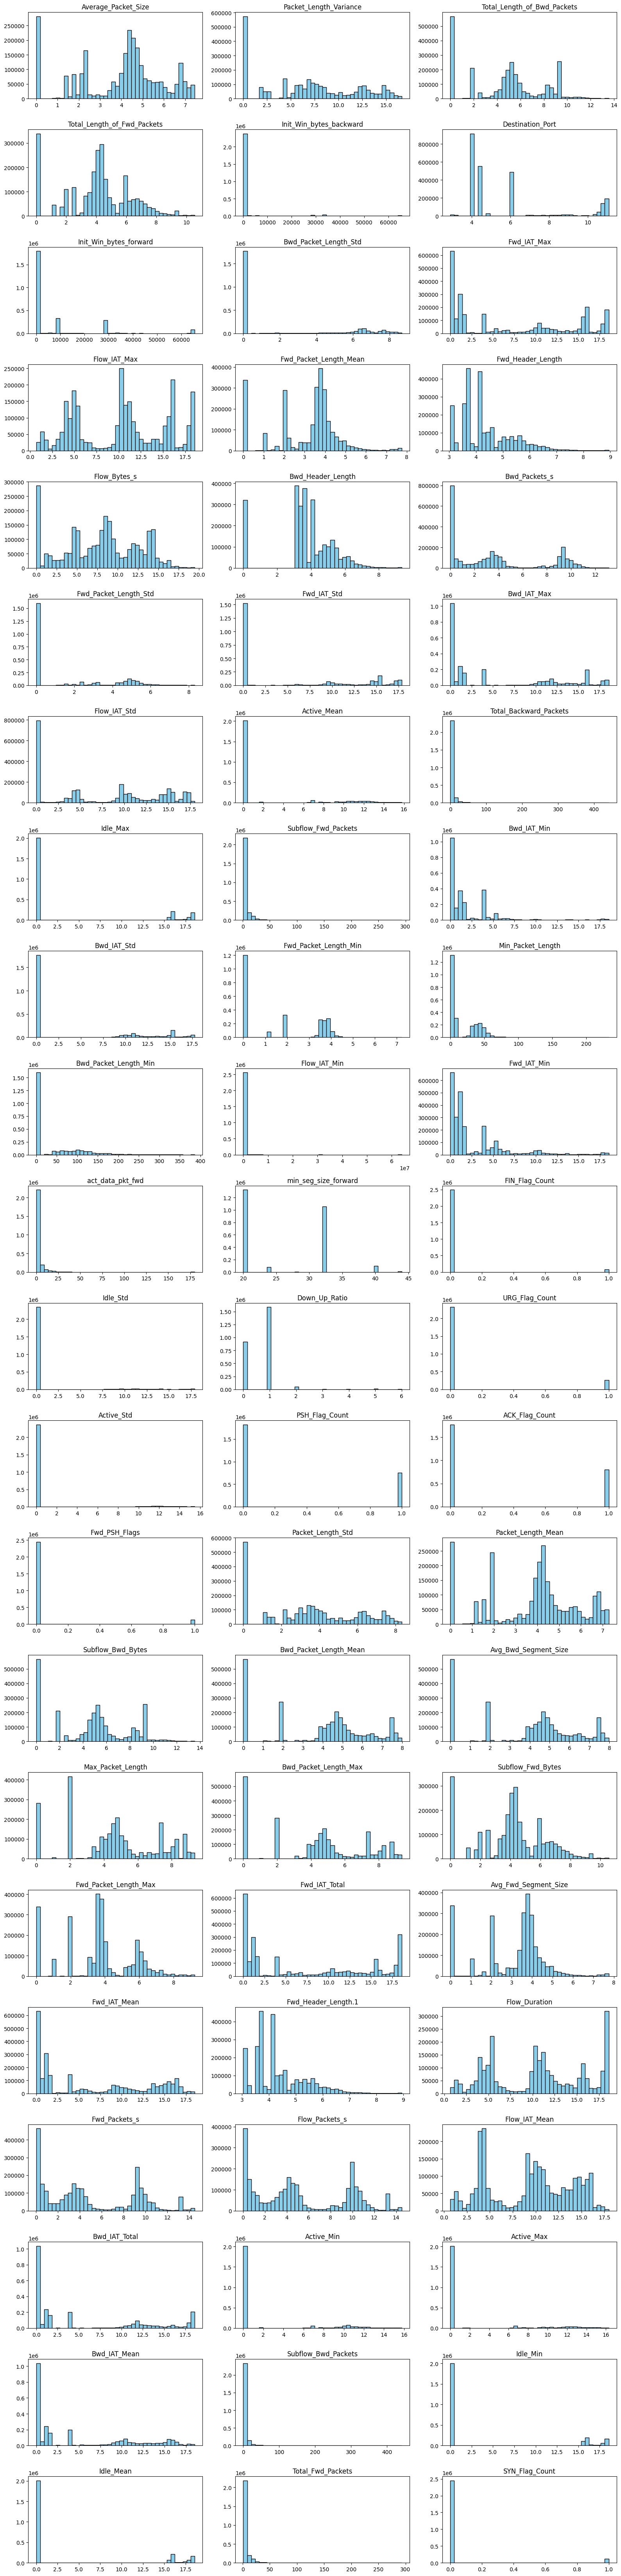

In [17]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import math

# Load prepared data
PREPARED_PATH = "models/hybrid_snortml/prepared_for_ae.joblib"
prepared = joblib.load(PREPARED_PATH)

selected_cols = prepared["selected_cols"]

# Load data sebelum scaling
df = joblib.load("models/hybrid_snortml/df_selected_clean_tmp.joblib")
df = df['df_selected_clean_tmp']

# Keep only selected features
df_sel = df[selected_cols]

# Plot histogram untuk setiap fitur
num_features = len(selected_cols)
cols = 3
rows = math.ceil(num_features / cols)

plt.figure(figsize=(16, rows * 3))

for i, col in enumerate(selected_cols):
    plt.subplot(rows, cols, i+1)
    plt.hist(df_sel[col], bins=40, color="skyblue", edgecolor="black")
    plt.title(col)
    plt.tight_layout()

plt.show()


In [19]:
# Build AE 
n_features = Xtr_scaled.shape[1]
tf.random.set_seed(RANDOM_STATE)

inp = layers.Input(shape=(n_features,), name='ae_input')
x = layers.GaussianNoise(AE_NOISE_STD)(inp)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
z = layers.Dense(BOTTLENECK, activation='relu', name='bottleneck')(x)
x = layers.Dense(128, activation='relu')(z)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
out = layers.Dense(n_features, activation='linear')(x)

ae = models.Model(inputs=inp, outputs=out, name='denoising_ae')
ae.compile(optimizer=optimizers.Adam(AE_LR), loss='mse')
ae.summary()

cb_ae = [
    callbacks.ModelCheckpoint(AE_BEST_PATH, monitor='val_loss', save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)
]


Model: "denoising_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 66)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 66)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 66)             │        16,962 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,434 (431.38 KB)

 Trainable params: 109,410 (427.38 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [20]:
# Prepare AE train/val benign sets 
if not USE_ALL_BENIGN and Xtr_benign.shape[0] > MAX_BENIGN_FOR_AE:
    rng = np.random.default_rng(RANDOM_STATE)
    idx = rng.choice(Xtr_benign.shape[0], size=MAX_BENIGN_FOR_AE, replace=False)
    Xtr_benign_train = Xtr_benign[idx]
else:
    Xtr_benign_train = Xtr_benign

if 'BENIGN' in y_val.astype(str).str.upper().values:
    mask_val_ben = (y_val.astype(str).str.upper() == 'BENIGN').values
    Xval_benign_all = Xv_scaled[mask_val_ben]
else:
    Xval_benign_all = Xv_scaled

VAL_BENIGN_CAP = 50_000
if Xval_benign_all.shape[0] > VAL_BENIGN_CAP:
    Xval_benign = Xval_benign_all[:VAL_BENIGN_CAP]
else:
    Xval_benign = Xval_benign_all

print("AE training benign shape:", Xtr_benign_train.shape, "AE val benign shape:", Xval_benign.shape)

AE training benign shape: (200000, 66) AE val benign shape: (50000, 66)


In [ ]:
# Fit AE 
history_ae = ae.fit(
    Xtr_benign_train, Xtr_benign_train,
    validation_data=(Xval_benign, Xval_benign),
    epochs=AE_EPOCHS, batch_size=AE_BATCH,
    callbacks=cb_ae, verbose=2
)

encoder = models.Model(ae.input, ae.get_layer('bottleneck').output)
encoder.save(ENCODER_PATH)
ae.save(AE_BEST_PATH)
print("Saved AE & encoder:", AE_BEST_PATH, ENCODER_PATH)



Epoch 1/120

Epoch 1: val_loss improved from inf to 0.01298, saving model to models/hybrid_snortml\best_ae.keras
782/782 - 5s - 7ms/step - loss: 0.0466 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 2/120

Epoch 2: val_loss improved from 0.01298 to 0.00863, saving model to models/hybrid_snortml\best_ae.keras
782/782 - 2s - 3ms/step - loss: 0.0133 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 3/120

Epoch 3: val_loss improved from 0.00863 to 0.00712, saving model to models/hybrid_snortml\best_ae.keras
782/782 - 2s - 3ms/step - loss: 0.0099 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 4/120

Epoch 4: val_loss improved from 0.00712 to 0.00598, saving model to models/hybrid_snortml\best_ae.keras
782/782 - 2s - 3ms/step - loss: 0.0082 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 5/120

Epoch 5: val_loss improved from 0.00598 to 0.00541, saving model to models/hybrid_snortml\best_ae.keras
782/782 - 3s - 4ms/step - loss: 0.0071 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 6/1

In [26]:
# Compute reconstructions & latents for classifier inputs 
print("Computing reconstructions & latents (may take time)...")
t0 = time.time()
# ensure using the best AE weights: reload to be safe
ae = models.load_model(AE_BEST_PATH, compile=False)
encoder = models.load_model(ENCODER_PATH, compile=False)
recon_tr = ae.predict(Xtr_scaled, batch_size=1024, verbose=0)
recon_val = ae.predict(Xv_scaled, batch_size=1024, verbose=0)
recon_te = ae.predict(Xte_scaled, batch_size=1024, verbose=0)
mse_tr = np.mean((Xtr_scaled - recon_tr)**2, axis=1)
mse_val = np.mean((Xv_scaled - recon_val)**2, axis=1)
mse_te  = np.mean((Xte_scaled - recon_te)**2, axis=1)
lat_tr = encoder.predict(Xtr_scaled, batch_size=1024, verbose=0)
lat_val = encoder.predict(Xv_scaled, batch_size=1024, verbose=0)
lat_te  = encoder.predict(Xte_scaled, batch_size=1024, verbose=0)
print("Done in {:.1f}s".format(time.time()-t0))

# build classifier inputs (latent + mse)
Xc_tr = np.concatenate([lat_tr, mse_tr.reshape(-1,1)], axis=1)
Xc_val = np.concatenate([lat_val, mse_val.reshape(-1,1)], axis=1)
Xc_te  = np.concatenate([lat_te, mse_te.reshape(-1,1)], axis=1)

print("Xc_tr:", Xc_tr.shape, "Xc_val:", Xc_val.shape, "Xc_te:", Xc_te.shape)

# prepare binary labels 
ytr_bin = (~y_train.str.upper().eq('BENIGN')).astype(int).values
yv_bin  = (~y_val.str.upper().eq('BENIGN')).astype(int).values
yte_bin = (~y_test.str.upper().eq('BENIGN')).astype(int).values

if Xc_tr.shape[0] != ytr_bin.shape[0] or Xc_val.shape[0] != yv_bin.shape[0] or Xc_te.shape[0] != yte_bin.shape[0]:
    raise RuntimeError("Shape mismatch between classifier matrices and labels. Check prepared data ordering.")

Computing reconstructions & latents (may take time)...
Done in 17.8s
Xc_tr: (1801984, 33) Xc_val: (386140, 33) Xc_te: (386140, 33)


In [27]:
from sklearn.metrics import f1_score

best_t = None
best_f1 = -1

for t in np.linspace(min(mse_val), max(mse_val), 200):
    preds = (mse_val >= t).astype(int)   # attack = high MSE
    f1 = f1_score(yv_bin, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best AE threshold =", best_t)
print("Best F1 on val =", best_f1)


Best AE threshold = 0.0035326537071154207
Best F1 on val = 0.8547212883410119


In [30]:
from sklearn.metrics import classification_report
import pandas as pd

# === Classification Report (formatted like your example) ===

target_names = ["0 (Normal)", "1 (Attack)"]

# Buat classification report dalam bentuk dictionary
report_dict = classification_report(
    yte_bin, 
    ae_preds,       # <- sesuai variabel kamu
    target_names=target_names,
    output_dict=True,
    zero_division=0
)

# Convert ke dataframe
df_report = pd.DataFrame(report_dict).T

# Urutkan kolom biar rapi
df_report = df_report[['precision','recall','f1-score','support']]

# Format angka
df_report['precision'] = df_report['precision'].map(lambda x: f"{x:.4f}" if isinstance(x,float) else x)
df_report['recall']    = df_report['recall'].map(lambda x: f"{x:.4f}" if isinstance(x,float) else x)
df_report['f1-score']  = df_report['f1-score'].map(lambda x: f"{x:.4f}" if isinstance(x,float) else x)

# Support diformat pakai pemisah ribuan
df_report['support']   = df_report['support'].astype(int).map(lambda x: f"{x:,}")

print(df_report)


             precision  recall f1-score  support
0 (Normal)      0.9625  0.9843   0.9733  322,258
1 (Attack)      0.9104  0.8067   0.8554   63,882
accuracy        0.9549  0.9549   0.9549        0
macro avg       0.9364  0.8955   0.9143  386,140
weighted avg    0.9539  0.9549   0.9538  386,140


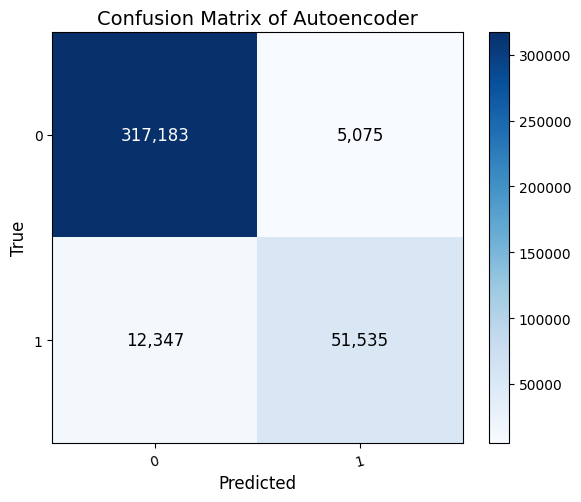

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# === CONFUSION MATRIX ===
cm = confusion_matrix(yte_bin, ae_preds)
classes = ["0", "1"]

plt.figure(figsize=(6,5))
im = plt.imshow(cm, cmap="Blues")

plt.title("Confusion Matrix of Autoencoder", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)

# axis tick labels
plt.xticks(np.arange(len(classes)), classes, rotation=15)
plt.yticks(np.arange(len(classes)), classes)

# annotate tiap sel dengan angka + pemisah ribuan
max_val = cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value_str = f"{cm[i, j]:,}"
        color = "white" if cm[i, j] > max_val * 0.5 else "black"
        plt.text(j, i, value_str,
                ha="center", va="center",
                fontsize=12, color=color)

# colorbar
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()


=== Autoencoder Evaluation (Test Set) ===
ROC AUC : 0.9642
PR AUC  : 0.9057


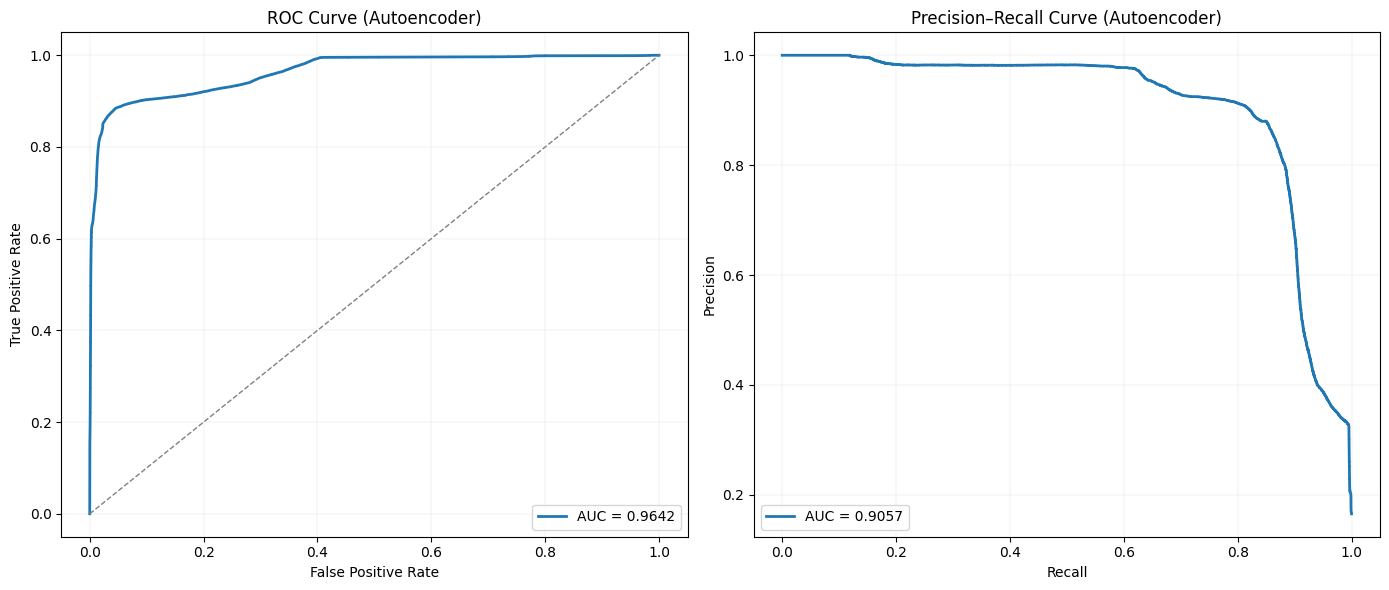

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# === ROC AUC untuk AE (skor = MSE) ===
roc_auc_ae = roc_auc_score(yte_bin, mse_te)
fpr, tpr, thresholds = roc_curve(yte_bin, mse_te)

# === Precision–Recall Curve ===
precision, recall, pr_thresholds = precision_recall_curve(yte_bin, mse_te)
pr_auc = auc(recall, precision)

print("=== Autoencoder Evaluation (Test Set) ===")
print(f"ROC AUC : {roc_auc_ae:.4f}")
print(f"PR AUC  : {pr_auc:.4f}")

plt.figure(figsize=(12, 5))

# ---- Subplot 1: ROC ----
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], '--', alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
# ---- Subplot 2: PR ----
plt.subplot(1, 2, 2)
plt.plot(rec_curve, prec_curve, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
# === SIDE-BY-SIDE PLOTS ===
plt.figure(figsize=(12, 5))

# ---- Left: ROC Curve ----
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_ae:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], '--', alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Autoencoder)")
plt.legend(loc="lower right")
plt.grid(True, linewidth=0.3, alpha=0.4)

# ---- Right: Precision–Recall Curve ----
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUC = {pr_auc:.4f}", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Autoencoder)")
plt.legend(loc="lower left")
plt.grid(True, linewidth=0.3, alpha=0.4)

plt.tight_layout()
plt.show()


In [ ]:
# Build / load final classifier 
if RUN_LOAD_CLS_FROM_SWEEP and os.path.exists(BEST_CLS_PATH):
    clf = models.load_model(BEST_CLS_PATH, compile=False)
    clf.compile(optimizer=optimizers.Adam(CLS_LR), loss='binary_crossentropy', metrics=['AUC'])
    print("Loaded classifier from disk (skipping training).")
else:
    latent_dim = Xc_tr.shape[1]
    inp_c = layers.Input(shape=(latent_dim,), name='clf_input')
    y = layers.Dense(128, activation='relu')(inp_c)
    y = layers.Dropout(0.3)(y)
    y = layers.Dense(32, activation='relu')(y)
    out_c = layers.Dense(1, activation='sigmoid')(y)
    clf = models.Model(inp_c, out_c, name='classifier_final')
    clf.compile(optimizer=optimizers.Adam(CLS_LR), loss='binary_crossentropy', metrics=['AUC'])
    clf.summary()

    # compute class weights
    classes = np.unique(ytr_bin)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=ytr_bin)
    class_weights = {int(c): float(w) for c,w in zip(classes, cw)}
    print("Using class_weights:", class_weights)

    cb_cls = [
        callbacks.ModelCheckpoint(BEST_CLS_PATH, monitor='val_AUC', save_best_only=True, mode='max', verbose=1),
        callbacks.EarlyStopping(monitor='val_AUC', patience=12, restore_best_weights=True, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(monitor='val_AUC', factor=0.5, patience=6, min_lr=1e-6, mode='max', verbose=1)
    ]

    history_clf = clf.fit(
        Xc_tr, ytr_bin,
        validation_data=(Xc_val, yv_bin),
        epochs=CLS_EPOCHS, batch_size=CLS_BATCH,
        class_weight=class_weights,
        callbacks=cb_cls,
        verbose=2
    )

    clf.save(BEST_CLS_PATH)
    print("Classifier trained & saved to:", BEST_CLS_PATH)

Model: "classifier_final"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ clf_input (InputLayer)          │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,513 (33.25 KB)

 Trainable params: 8,513 (33.25 KB)

 Non-trainable params: 0 (0.00 B)

Using class_weights: {0: 0.5991156150465133, 1: 3.0223069027284866}
Epoch 1/80

Epoch 1: val_AUC improved from -inf to 0.99906, saving model to models/hybrid_snortml\best_classifier.keras
7039/7039 - 7s - 991us/step - AUC: 0.9950 - loss: 0.0852 - val_AUC: 0.9991 - val_loss: 0.0222 - learning_rate: 1.0000e-04
Epoch 2/80

Epoch 2: val_AUC improved from 0.99906 to 0.99942, saving model to models/hybrid_snortml\best_classifier.keras
7039/7039 - 6s - 852us/step - AUC: 0.9991 - loss: 0.0282 - val_AUC: 0.9994 - val_loss: 0.0150 - learning_rate: 1.0000e-04
Epoch 3/80

Epoch 3: val_AUC improved from 0.99942 to 0.99953, saving model to models/hybrid_snortml\best_classifier.keras
7039/7039 - 6s - 844us/step - AUC: 0.9994 - loss: 0.0201 - val_AUC: 0.9995 - val_loss: 0.0118 - learning_rate: 1.0000e-04
Epoch 4/80

Epoch 4: val_AUC improved from 0.99953 to 0.99954, saving model to models/hybrid_snortml\best_classifier.keras
7039/7039 - 6s - 840us/step - AUC: 0.9995 - loss: 0.0164 - val_AUC: 0.9995 - 

In [32]:
# Evaluation on test set 
clf = models.load_model(BEST_CLS_PATH, compile=False)
probs_te = clf.predict(Xc_te, batch_size=1024, verbose=0).ravel()
probs_val = clf.predict(Xc_val, batch_size=1024, verbose=0).ravel()

# ROC/PR / AUC
roc_auc = roc_auc_score(yte_bin, probs_te)
prec_curve, rec_curve, pr_thresh = precision_recall_curve(yte_bin, probs_te)
pr_auc = auc(rec_curve, prec_curve)

# find best threshold on val (F1)
best_f1 = -1; best_thresh = 0.5
for t in np.linspace(0.01, 0.99, 99):
    f1t = f1_score(yv_bin, (probs_val >= t).astype(int))
    if f1t > best_f1:
        best_f1 = f1t; best_thresh = t

metrics_at_05 = {}
metrics_at_best = {}
def compute_metrics_for(y_true, probs, thresh):
    preds = (probs >= thresh).astype(int)
    cm = confusion_matrix(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0)
    rec = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    return {'threshold': float(thresh), 'precision': float(prec), 'recall': float(rec), 'f1': float(f1), 'confusion_matrix': cm}

metrics_at_05 = compute_metrics_for(yte_bin, probs_te, 0.5)
metrics_at_best = compute_metrics_for(yte_bin, probs_te, best_thresh)

brier = brier_score_loss(yte_bin, probs_te)

print("\n=== Test metrics ===")
print("ROC AUC :", roc_auc)
print("PR AUC  :", pr_auc)
print("-- at threshold 0.5 --", metrics_at_05)
print("-- at best threshold (val tuned) --", metrics_at_best)
print("Best threshold on VAL by F1 =", best_thresh, "F1=", best_f1)
print("Saved evaluation dict to:", EVAL_OUT)

# save
eval_out = {
    'roc_auc': float(roc_auc), 'pr_auc': float(pr_auc),
    'brier': float(brier), 'best_val_threshold': float(best_thresh),
    'metrics_at_0.5': metrics_at_05, 'metrics_at_best': metrics_at_best,
    'probs_te': probs_te, 'probs_val': probs_val, 'yte_bin': yte_bin, 'yv_bin': yv_bin
}
joblib.dump(eval_out, EVAL_OUT)



=== Test metrics ===
ROC AUC : 0.9999333514214329
PR AUC  : 0.9996995936681387
-- at threshold 0.5 -- {'threshold': 0.5, 'precision': 0.9880932078572425, 'recall': 0.9976675745906515, 'f1': 0.9928573097684272, 'confusion_matrix': array([[321490,    768],
       [   149,  63733]], dtype=int64)}
-- at best threshold (val tuned) -- {'threshold': 0.79, 'precision': 0.9967010179715974, 'recall': 0.9931749162518393, 'f1': 0.9949348429487682, 'confusion_matrix': array([[322048,    210],
       [   436,  63446]], dtype=int64)}
Best threshold on VAL by F1 = 0.79 F1= 0.9952885286255203
Saved evaluation dict to: models/hybrid_snortml\final_eval_metrics.joblib


['models/hybrid_snortml\\final_eval_metrics.joblib']

In [35]:
from sklearn.metrics import classification_report
import pandas as pd

# === Prediksi final classifier ===
clf_preds = (probs_te >= best_thresh).astype(int)

target_names = ["0 (Normal)", "1 (Attack)"]

# Ambil classification report dalam bentuk dictionary
report_dict = classification_report(
    yte_bin,
    clf_preds,
    target_names=target_names,
    output_dict=True,
    zero_division=0
)

# Convert ke dataframe
df_report = pd.DataFrame(report_dict).T

# Ambil kolom yang diperlukan
df_report = df_report[['precision','recall','f1-score','support']]

# Format angka seperti gambar (4 decimal)
df_report['precision'] = df_report['precision'].map(lambda x: f"{x:.4f}" if isinstance(x,float) else x)
df_report['recall']    = df_report['recall'].map(lambda x: f"{x:.4f}" if isinstance(x,float) else x)
df_report['f1-score']  = df_report['f1-score'].map(lambda x: f"{x:.4f}" if isinstance(x,float) else x)

# Support → integer dengan pemisah ribuan
df_report['support']   = df_report['support'].astype(int).map(lambda x: f"{x:,}")

print(df_report)


             precision  recall f1-score  support
0 (Normal)      0.9986  0.9993   0.9990  322,258
1 (Attack)      0.9967  0.9932   0.9949   63,882
accuracy        0.9983  0.9983   0.9983        0
macro avg       0.9977  0.9963   0.9970  386,140
weighted avg    0.9983  0.9983   0.9983  386,140


In [36]:
OUT_DIR = MODEL_DIR

# TFLite conversion (classifier + encoder) 
def convert_and_save_keras_to_tflite(model, out_path, optimizations=None, rep_ds=None, float16=False):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if optimizations is not None:
        converter.optimizations = optimizations
    if rep_ds is not None:
        converter.representative_dataset = rep_ds
    if float16:
        converter.target_spec.supported_types = [tf.float16]
    tflite_model = converter.convert()
    with open(out_path, "wb") as f:
        f.write(tflite_model)
    print("Saved TFLite to:", out_path)

# classifier float32
cls_tflite_f32 = os.path.join(OUT_DIR, "ae_classifier_model.tflite")
convert_and_save_keras_to_tflite(clf, cls_tflite_f32, optimizations=None)

try:
    interpreter = tf.lite.Interpreter(model_path=cls_tflite_f32)
    interpreter.allocate_tensors()
    inp_det = interpreter.get_input_details()[0]
    out_det = interpreter.get_output_details()[0]
    # prepare sample: first N rows (respect batch dim expected)
    sample = Xc_te[:max(1, min(8, Xc_te.shape[0]))].astype(np.float32)
    # some TFLite models expect fixed batch size; try to reshape if necessary
    if inp_det['shape'][0] != sample.shape[0]:
        # try to use dynamic batch if supported by resizing
        try:
            interpreter.resize_tensor_input(inp_det['index'], sample.shape, strict=False)
            interpreter.allocate_tensors()
        except Exception:
            pass
    interpreter.set_tensor(interp := interpreter.get_input_details()[0]['index'], sample)
    interpreter.invoke()
    out = interpreter.get_tensor(out_det['index'])
    print("TFLite sample outputs:", out.ravel()[:8])
except Exception as e:
    print("TFLite runtime sanity check failed:", e)

INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpf6191cpf\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpf6191cpf\assets


Saved artifact at 'C:\Users\HP\AppData\Local\Temp\tmpf6191cpf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 33), dtype=tf.float32, name='clf_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1721242267728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1721242271376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1721242273552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1721242272208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1721242272400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1721242283728: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved TFLite to: models/hybrid_snortml\ae_classifier_model.tflite
TFLite sample outputs: [2.3123385e-10 4.0522159e-06 5.8465757e-33 6.7645237e-11 1.0000000e+00
 3.9257498e-06 5.5735785e-07 4.0639898e-05]


In [37]:
# ---------- Save deployment metadata ----------
joblib.dump({
    'selected_cols': selected_cols,
    'bottleneck': BOTTLENECK,
    'ae_path': AE_BEST_PATH,
    'encoder_path': ENCODER_PATH,
    'clf_path': BEST_CLS_PATH,
    'eval_path': EVAL_OUT
}, DEPLOY_META)

print("Saved deploy metadata to:", DEPLOY_META)

print("\nPipeline finished. Files in:", MODEL_DIR)

Saved deploy metadata to: models/hybrid_snortml\deploy_metadata.joblib

Pipeline finished. Files in: models/hybrid_snortml


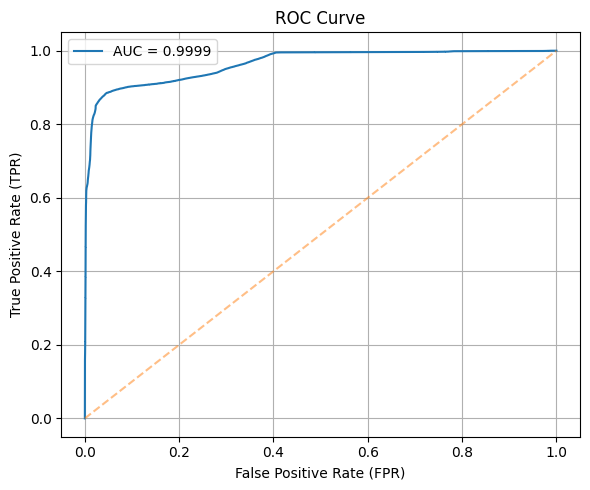

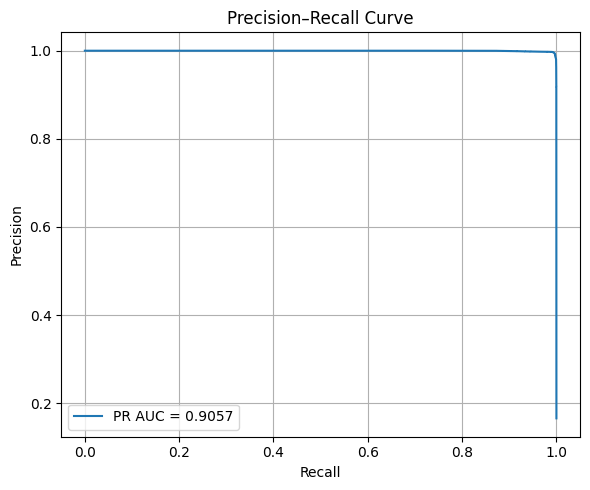

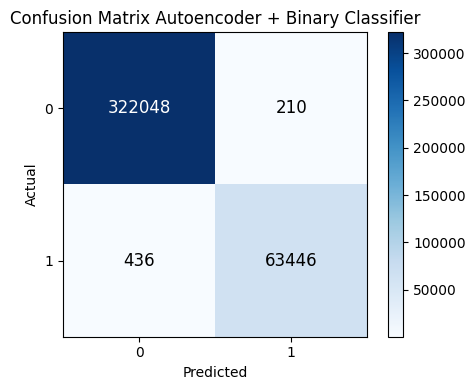

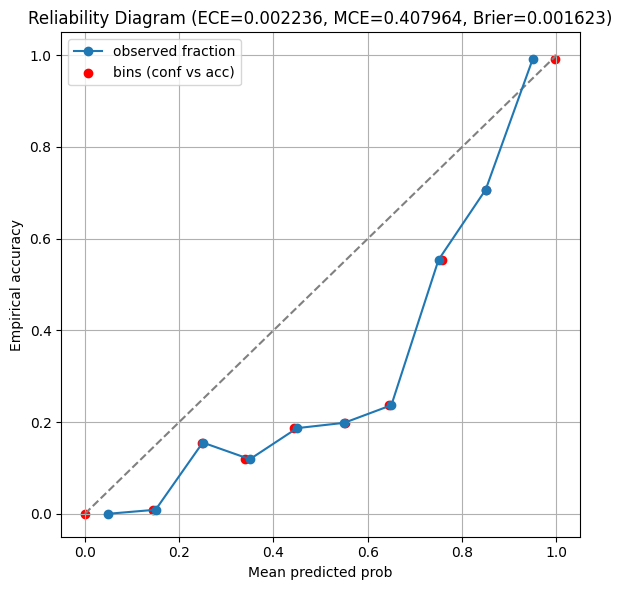

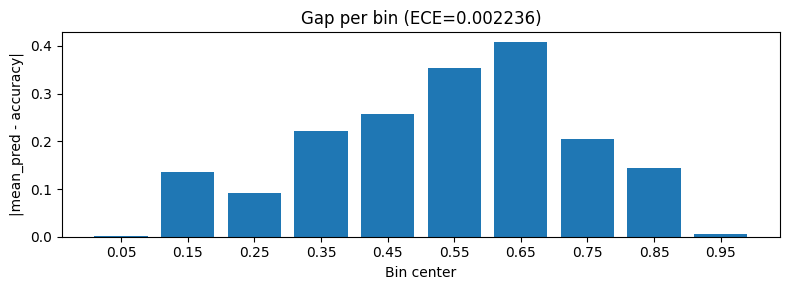

Saved plots & summary to: models/hybrid_snortml


In [53]:


# ---- Subplot 1: ROC ----
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], '--', alpha=0.5)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Subplot 2: PR ----
plt.figure(figsize=(6, 5))
plt.plot(rec_curve, prec_curve, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion (best thresh)
cm = metrics_at_best['confusion_matrix']

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')

plt.title(f"Confusion Matrix Autoencoder + Binary Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.xticks([0,1], ['0','1'])
plt.yticks([0,1], ['0','1'])

max_val = cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        # Threshold untuk menentukan warna teks
        text_color = "white" if value > max_val * 0.5 else "black"
        plt.text(j, i, str(int(value)), ha='center', va='center', color=text_color, fontsize=12)

plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_best.png"), dpi=200)
plt.show()

# Calibration (reliability diagram)
from sklearn.calibration import calibration_curve
n_bins = 10
frac_pos, mean_pred = calibration_curve(yte_bin, probs_te, n_bins=n_bins)
# compute counts per bin for gap/ECE
bins = np.linspace(0.0,1.0,n_bins+1)
bin_ids = np.digitize(probs_te, bins) - 1
counts = np.array([np.sum(bin_ids==i) for i in range(n_bins)])
mean_pred_bins = np.array([probs_te[bin_ids==i].mean() if counts[i]>0 else np.nan for i in range(n_bins)])
frac_pos_bins = np.array([yte_bin[bin_ids==i].mean() if counts[i]>0 else np.nan for i in range(n_bins)])
abs_gap = np.abs(np.nan_to_num(mean_pred_bins) - np.nan_to_num(frac_pos_bins))
ece = float((abs_gap * (counts/ max(1, counts.sum()))).sum())
mce = float(np.nanmax(abs_gap))
brier = float(brier)

plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],'--',color='gray')
centers = (bins[:-1]+bins[1:]) / 2.0
plt.plot(centers, frac_pos_bins, marker='o', label='observed fraction')
plt.scatter(mean_pred_bins, frac_pos_bins, c='red', label='bins (conf vs acc)')

plt.xlabel("Mean predicted prob"); plt.ylabel("Empirical accuracy")
plt.title(f"Reliability Diagram (ECE={ece:.6f}, MCE={mce:.6f}, Brier={brier:.6f})")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"calibration_reliability_test.png"), dpi=200); 
plt.show()

# Gap per bin
plt.figure(figsize=(8,3))
plt.bar(range(len(abs_gap)), abs_gap, tick_label=[f"{c:.2f}" for c in centers])
plt.xlabel("Bin center"); plt.ylabel("|mean_pred - accuracy|")
plt.title(f"Gap per bin (ECE={ece:.6f})"); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"gap_per_bin.png"), dpi=200); 
plt.show()

# save summary joblib
joblib.dump({
    'roc_auc': roc_auc, 'pr_auc': pr_auc, 'brier': brier,
    'ece': ece, 'mce': mce, 'best_val_threshold': best_thresh,
    'metrics_at_0.5': metrics_at_05, 'metrics_at_best': metrics_at_best
}, os.path.join(OUT_DIR,"final_eval_summary.joblib"))

print("Saved plots & summary to:", OUT_DIR)


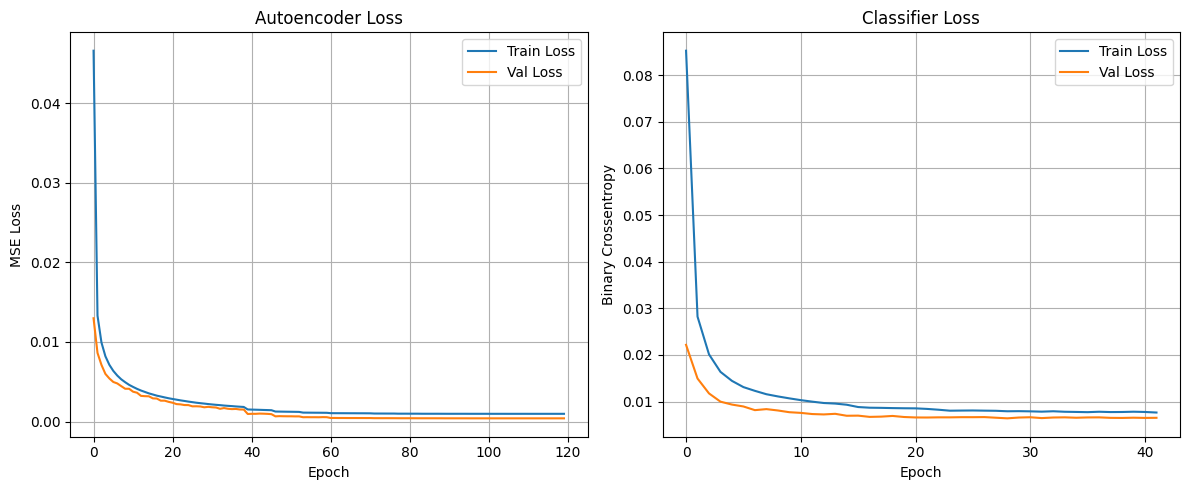

Saved side-by-side loss plot to: models/hybrid_snortml\loss_side_by_side.png


In [40]:
import os, joblib
import matplotlib.pyplot as plt

OUT_DIR = "models/hybrid_snortml"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- Helper: load history safely ----
def load_hist(name):
    # from memory
    if name in globals():
        h = globals()[name]
        if hasattr(h, "history"):
            return dict(h.history)
        if isinstance(h, dict):
            return h
    # from joblib
    path = os.path.join(OUT_DIR, f"{name}.joblib")
    if os.path.exists(path):
        try:
            h = joblib.load(path)
            if hasattr(h, "history"):
                return dict(h.history)
            if isinstance(h, dict):
                return h
        except:
            pass
    return None

# try read both
hist_ae  = load_hist("history_ae")
hist_clf = load_hist("history_clf")

if hist_ae is None:
    print("Warning: history_ae not found.")
if hist_clf is None:
    print("Warning: history_clf not found.")

# ---- Extract losses ----
ae_loss = hist_ae.get("loss") if hist_ae else None
ae_val  = hist_ae.get("val_loss") if hist_ae else None

clf_loss = hist_clf.get("loss") if hist_clf else None
clf_val  = hist_clf.get("val_loss") if hist_clf else None

if ae_loss is None or clf_loss is None:
    raise RuntimeError("AE or Classifier loss history not found. Ensure history_ae/history_clf exist.")

# ---- Plot side-by-side ----
plt.figure(figsize=(12,5))

# --- Left: AE loss ---
plt.subplot(1, 2, 1)
plt.plot(ae_loss, label="Train Loss")
if ae_val is not None:
    plt.plot(ae_val, label="Val Loss")
plt.title("Autoencoder Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)

# --- Right: Classifier loss ---
plt.subplot(1, 2, 2)
plt.plot(clf_loss, label="Train Loss")
if clf_val is not None:
    plt.plot(clf_val, label="Val Loss")
plt.title("Classifier Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.grid(True)

plt.tight_layout()
out_path = os.path.join(OUT_DIR, "loss_side_by_side.png")
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved side-by-side loss plot to:", out_path)


[viz] data shape used: (50000, 32), labels: (array([0, 1]), array([41644,  8356], dtype=int64))


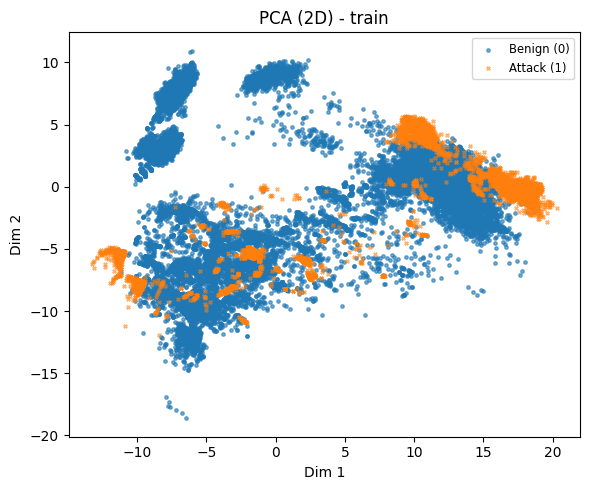

[viz] data shape used: (20000, 32), labels: (array([0, 1]), array([16708,  3292], dtype=int64))


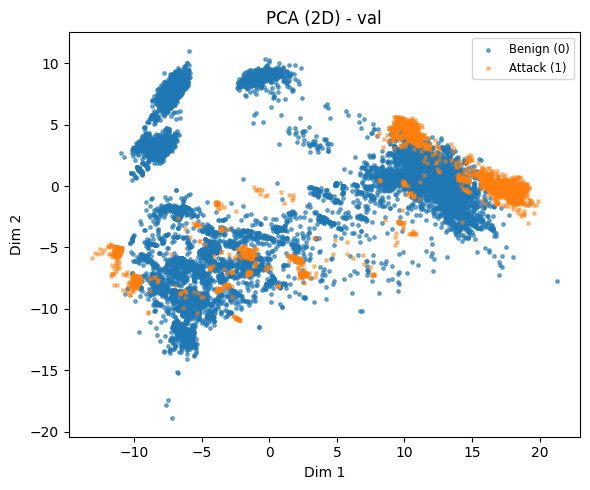

[viz] data shape used: (20000, 32), labels: (array([0, 1]), array([16704,  3296], dtype=int64))


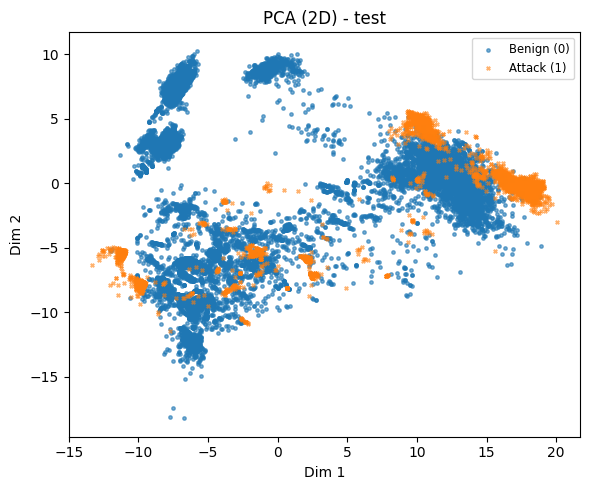

In [41]:
# latent_viz.py
# Requirements: numpy, matplotlib, sklearn, umap-learn (optional for UMAP)
# pip install umap-learn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    import umap
    _HAS_UMAP = True
except Exception:
    _HAS_UMAP = False

def maybe_subsample(X, y, max_samples=50000, rng_seed=42):
    """Subsample X,y to at most max_samples while preserving class ratio."""
    n = X.shape[0]
    if n <= max_samples:
        return X, y
    rng = np.random.default_rng(rng_seed)
    idx = rng.choice(n, size=max_samples, replace=False)
    return X[idx], y[idx]

def plot_2d_scatter(Z, y, title, out_path=None, figsize=(6,5), alpha=0.6, marker_size=6):
    """Plot 2D scatter of 2D embedding Z with binary labels y (0 benign, 1 attack)."""
    plt.figure(figsize=figsize)
    # plot benign first then attack so attack appears on top
    mask0 = (y == 0)
    mask1 = ~mask0
    plt.scatter(Z[mask0,0], Z[mask0,1], s=marker_size, alpha=alpha, label='Benign (0)')
    plt.scatter(Z[mask1,0], Z[mask1,1], s=marker_size, alpha=alpha, marker='x', label='Attack (1)')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.title(title)
    plt.legend(loc='best', fontsize='small')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=300)
    plt.show()
    plt.close()

def visualize_latent_space(latent, labels, name_prefix='train', max_samples=50000, rng_seed=42,
                        run_pca=True, run_tsne=True, run_umap=True, tsne_perplexity=30, tsne_n_iter=1000):
    """
    Produce PCA, t-SNE, UMAP 2D visualizations for given latent vectors and binary labels.
    - latent: ndarray (n_samples, latent_dim)
    - labels: ndarray (n_samples,) binary {0,1}
    """
    X, y = maybe_subsample(latent, labels, max_samples=max_samples, rng_seed=rng_seed)
    print(f"[viz] data shape used: {X.shape}, labels: {np.unique(y, return_counts=True)}")

    if run_pca:
        pca = PCA(n_components=2, random_state=rng_seed)
        Z_pca = pca.fit_transform(X)
        plot_2d_scatter(Z_pca, y, f'PCA (2D) - {name_prefix}', out_path=f'{name_prefix}_pca2d.png')

    if run_tsne:
        # t-SNE can be slow — adjust perplexity and n_iter for speed/quality tradeoff
        tsne = TSNE(n_components=2, perplexity=tsne_perplexity, n_iter=tsne_n_iter,
                    init='pca', random_state=rng_seed, verbose=1)
        Z_tsne = tsne.fit_transform(X)
        plot_2d_scatter(Z_tsne, y, f't-SNE (2D) - {name_prefix}', out_path=f'{name_prefix}_tsne2d.png')

    if run_umap:
        if not _HAS_UMAP:
            print("[viz] umap not installed; skipping UMAP. Install with `pip install umap-learn`.")
        else:
            reducer = umap.UMAP(n_components=2, random_state=rng_seed)
            Z_umap = reducer.fit_transform(X)
            plot_2d_scatter(Z_umap, y, f'UMAP (2D) - {name_prefix}', out_path=f'{name_prefix}_umap2d.png')

# ---------- Example usage ----------
# Use the latent arrays & labels you already have (lat_tr, lat_val, lat_te, ytr_bin, yv_bin, yte_bin)
# For a quick overview, visualize a subsampled portion (e.g., max_samples=50k):
if __name__ == '__main__':
    # visualize training latent
    visualize_latent_space(lat_tr, ytr_bin, name_prefix='train', max_samples=50000,
                        run_pca=True, run_tsne=False, run_umap=False,
                        tsne_perplexity=50, tsne_n_iter=1000)

    # visualize validation latent (smaller or full)
    visualize_latent_space(lat_val, yv_bin, name_prefix='val', max_samples=20000,
                        run_pca=True, run_tsne=False, run_umap=False)

    # visualize test latent
    visualize_latent_space(lat_te, yte_bin, name_prefix='test', max_samples=20000,
                        run_pca=True, run_tsne=False, run_umap=False)


PCA explained variance (2 comp): 0.588


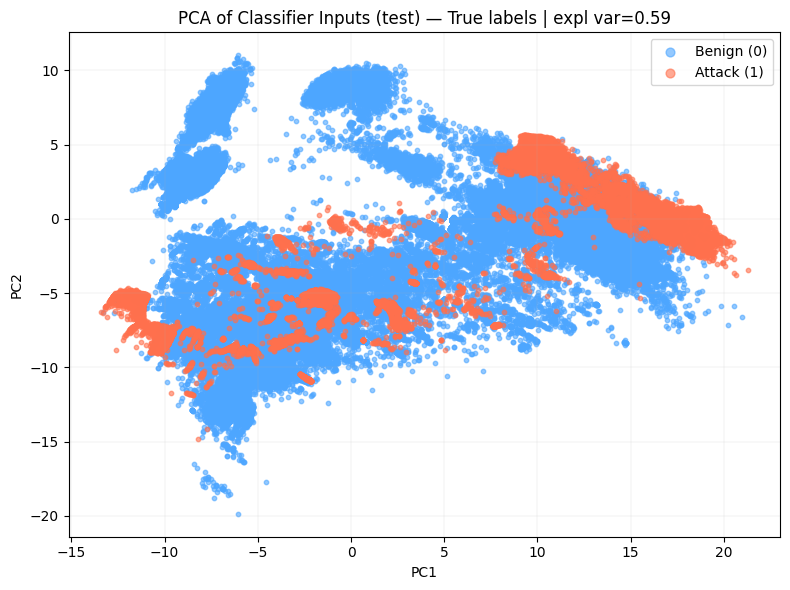

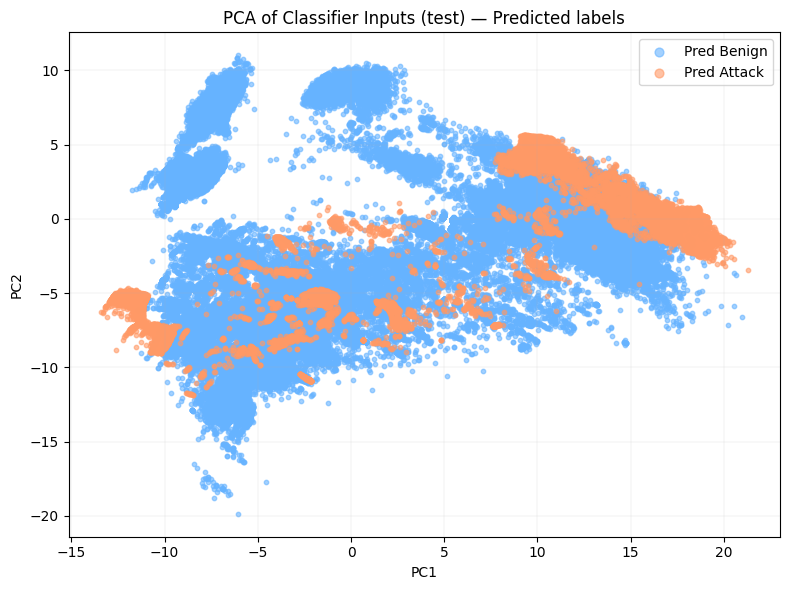

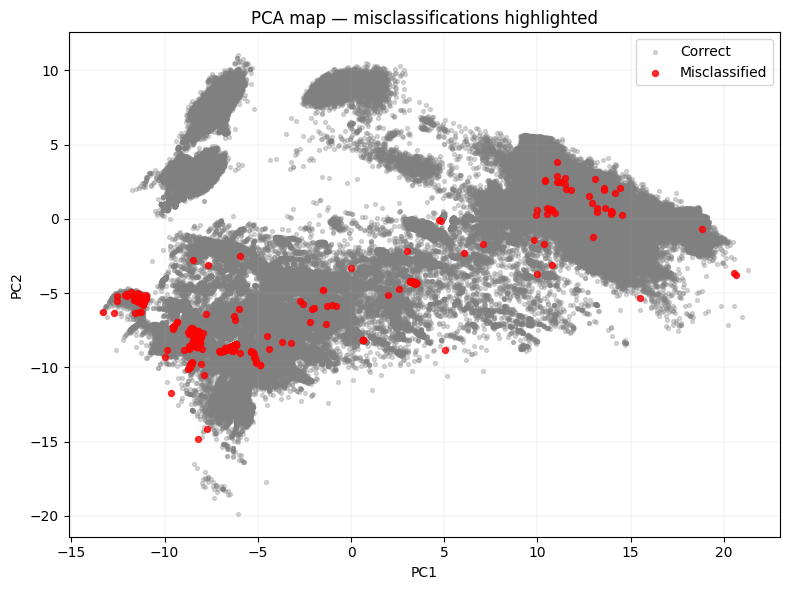

In [42]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

# paths (adjust if needed)
MODEL_DIR = "models/hybrid_snortml"
EVAL_OUT = Path(MODEL_DIR) / "final_eval_metrics.joblib"
# Xc_te must be available in your session; if not, load it from your prepared artifact or recreate it.

# -------------- load eval outputs if not in memory --------------
if 'probs_te' not in globals() or 'yte_bin' not in globals() or 'probs_val' not in globals() or 'best_thresh' not in globals():
    if EVAL_OUT.exists():
        ev = joblib.load(EVAL_OUT)
        probs_te = ev.get('probs_te', None)
        probs_val = ev.get('probs_val', None)
        yte_bin = ev.get('yte_bin', None)
        yv_bin = ev.get('yv_bin', None)
        best_thresh = ev.get('best_val_threshold', None)
        print("Loaded eval outputs from", EVAL_OUT)
    else:
        raise RuntimeError("Eval outputs not in memory and final_eval_metrics.joblib not found.")

# Ensure Xc_te is present
if 'Xc_te' not in globals():
    raise RuntimeError("Xc_te not found in session. Make sure you load/prepare classifier input matrix Xc_te (latent + mse for test set).")

# Convert to numpy arrays and ensure shapes match
Xc_te = np.asarray(Xc_te)
probs_te = np.asarray(probs_te).ravel()
yte_bin = np.asarray(yte_bin).astype(int).ravel()

assert Xc_te.shape[0] == probs_te.shape[0] == yte_bin.shape[0], "Shape mismatch between Xc_te, probs_te, and yte_bin"

# ---------- compute PCA coords ----------
# Best practice: if you saved a PCA fitted on train, load and use it here.
# Otherwise fit PCA on Xc_te for visualization only:
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xc_te)
explained = pca.explained_variance_ratio_.sum()
print(f"PCA explained variance (2 comp): {explained:.3f}")

# ---------- prepare plotting labels ----------
y_pred = (probs_te >= float(best_thresh)).astype(int) if best_thresh is not None else (probs_te >= 0.5).astype(int)

# Plot 1: True labels
plt.figure(figsize=(8,6))
for cls, color, label in [(0, '#4da6ff', 'Benign (0)'), (1, '#ff704d', 'Attack (1)')]:
    mask = (yte_bin == cls)
    plt.scatter(Z[mask,0], Z[mask,1], s=10, alpha=0.6, color=color, label=label)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"PCA of Classifier Inputs (test) — True labels | expl var={explained:.2f}")
plt.legend(markerscale=2); plt.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()

# Plot 2: Predicted labels
plt.figure(figsize=(8,6))
for cls, color, label in [(0, '#66b3ff', 'Pred Benign'), (1, '#ff9966', 'Pred Attack')]:
    mask = (y_pred == cls)
    plt.scatter(Z[mask,0], Z[mask,1], s=10, alpha=0.6, color=color, label=label)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA of Classifier Inputs (test) — Predicted labels")
plt.legend(markerscale=2); plt.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()

# Plot 3: Misclassified points highlighted
correct = (y_pred == yte_bin)
plt.figure(figsize=(8,6))
plt.scatter(Z[correct,0], Z[correct,1], s=8, alpha=0.3, color='gray', label='Correct')
plt.scatter(Z[~correct,0], Z[~correct,1], s=18, alpha=0.8, color='red', label='Misclassified')
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA map — misclassifications highlighted")
plt.legend(); plt.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()


t-SNE input samples: (50000, 33)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.004s...


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 50000 samples in 2.499s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sample 13000 / 50000
[t-SNE] Computed conditional probabilities for sample 14000 / 50000

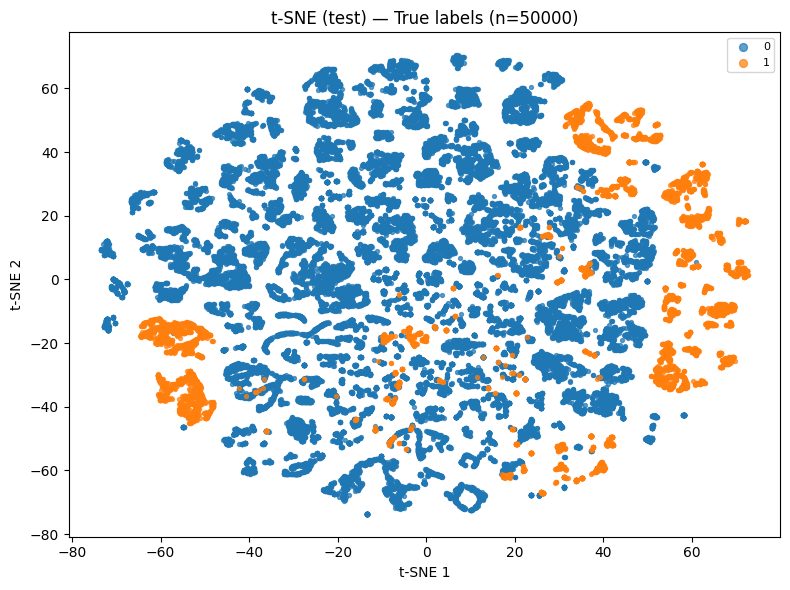

Saved: models/hybrid_snortml\tsne_true_50000.png


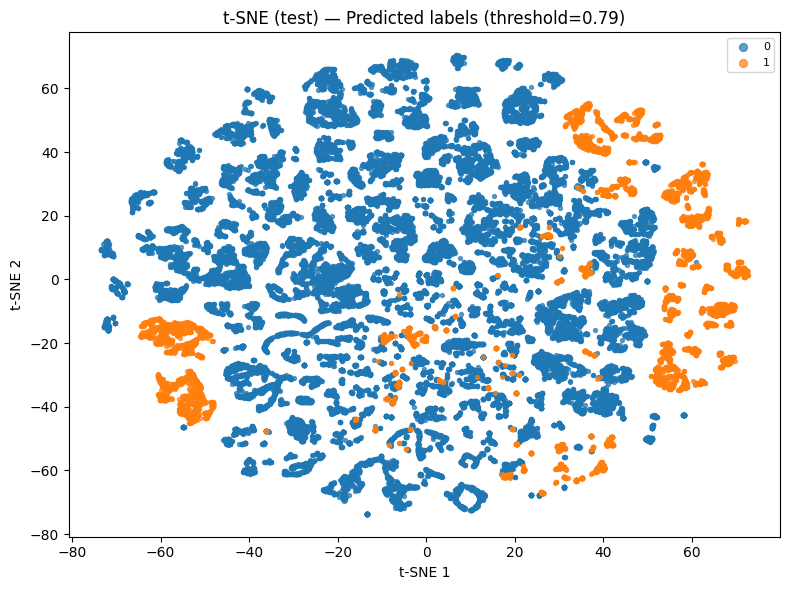

Saved: models/hybrid_snortml\tsne_pred_50000.png


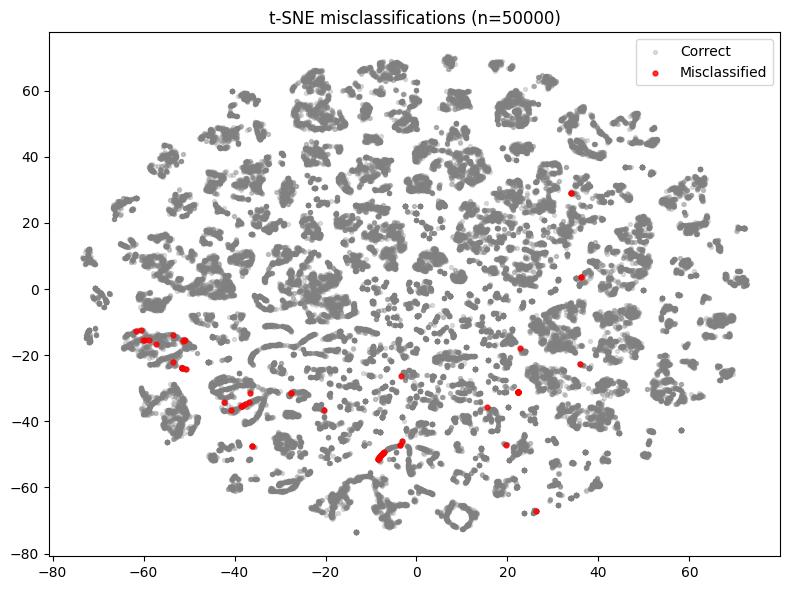

Saved: models/hybrid_snortml\tsne_miscls_50000.png
Saved coords CSV: models/hybrid_snortml\tsne_coords_50000.csv


In [43]:
# tsne_map.py
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pathlib import Path

MODEL_DIR = "models/hybrid_snortml"
EVAL_OUT = Path(MODEL_DIR) / "final_eval_metrics.joblib"

# ---- Parameters (tweakable) ----
random_state = 42
pca_dim_pre = 50       # PCA pre-reduction before t-SNE (set None to skip)
tsne_dim = 2
perplexity = 50        # try 30-50 for large datasets
n_iter = 1000          # 1000+ recommended
learning_rate = 200.0
sample_n = 50000       # subsample for plotting (None = use all)
save_dir = MODEL_DIR
os.makedirs(save_dir, exist_ok=True)
# --------------------------------

# --- load eval outputs if not in memory ---
if 'probs_te' not in globals() or 'yte_bin' not in globals() or 'best_thresh' not in globals():
    if EVAL_OUT.exists():
        ev = joblib.load(EVAL_OUT)
        probs_te = ev.get('probs_te', None)
        probs_val = ev.get('probs_val', None)
        yte_bin = ev.get('yte_bin', None)
        yv_bin = ev.get('yv_bin', None)
        best_thresh = ev.get('best_val_threshold', None)
        print("Loaded eval outputs from", EVAL_OUT)
    else:
        raise RuntimeError("Eval outputs not in memory and final_eval_metrics.joblib not found.")

# Ensure Xc_te present
if 'Xc_te' not in globals():
    raise RuntimeError("Xc_te not found in session. Prepare Xc_te (latent+MSE for test set).")

# convert & check shapes
Xc_te = np.asarray(Xc_te)
probs_te = np.asarray(probs_te).ravel()
yte_bin = np.asarray(yte_bin).astype(int).ravel()
assert Xc_te.shape[0] == probs_te.shape[0] == yte_bin.shape[0], "Shape mismatch between Xc_te, probs_te, and yte_bin"

# compute predictions using best_thresh (fallback 0.5)
th = float(best_thresh) if best_thresh is not None else 0.5
y_pred = (probs_te >= th).astype(int)

# optionally subsample for compute/plot speed
n_samples = Xc_te.shape[0]
if sample_n is not None and n_samples > sample_n:
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n_samples, size=sample_n, replace=False)
    X_sub = Xc_te[idx]
    y_sub = yte_bin[idx]
    preds_sub = y_pred[idx]
    probs_sub = probs_te[idx]
else:
    X_sub = Xc_te
    y_sub = yte_bin
    preds_sub = y_pred
    probs_sub = probs_te

print("t-SNE input samples:", X_sub.shape)

# PCA pre-reduction (recommended for high-dim / large N)
if pca_dim_pre is not None and pca_dim_pre < X_sub.shape[1]:
    pca = PCA(n_components=min(pca_dim_pre, X_sub.shape[1]), random_state=random_state)
    X_proc = pca.fit_transform(X_sub)
    print("PCA pre-reduction -> shape:", X_proc.shape)
else:
    X_proc = X_sub

# Run t-SNE
tsne = TSNE(n_components=tsne_dim, perplexity=perplexity, n_iter=n_iter,
            learning_rate=learning_rate, random_state=random_state, init='pca', verbose=1)
Z = tsne.fit_transform(X_proc)
print("t-SNE done, shape:", Z.shape)

# helper to plot scatter
def scatter_plot(Z, labels, title, filename, cmap=('tab10','tab20'), marker='o'):
    plt.figure(figsize=(8,6))
    unique = np.unique(labels)
    n_labels = unique.shape[0]
    cmap_use = plt.get_cmap('tab10' if n_labels<=10 else 'tab20')
    for i, lab in enumerate(unique):
        mask = (labels == lab)
        plt.scatter(Z[mask,0], Z[mask,1], s=8, alpha=0.7, label=str(lab), color=cmap_use(i))
    plt.title(title)
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.legend(loc='best', fontsize=8, markerscale=2)
    plt.grid(False)
    plt.tight_layout()
    outp = os.path.join(save_dir, filename)
    plt.savefig(outp, dpi=200)
    plt.show()
    print("Saved:", outp)

# Plot 1: true labels (Benign vs Attack)
scatter_plot(Z, y_sub, f"t-SNE (test) — True labels (n={Z.shape[0]})", f"tsne_true_{Z.shape[0]}.png")

# Plot 2: predicted labels
scatter_plot(Z, preds_sub, f"t-SNE (test) — Predicted labels (threshold={th:.2f})", f"tsne_pred_{Z.shape[0]}.png")

# Plot 3: misclassifications highlighted
correct_mask = (preds_sub == y_sub)
plt.figure(figsize=(8,6))
plt.scatter(Z[correct_mask,0], Z[correct_mask,1], s=8, alpha=0.25, color='gray', label='Correct')
plt.scatter(Z[~correct_mask,0], Z[~correct_mask,1], s=12, alpha=0.8, color='red', label='Misclassified')
plt.title(f"t-SNE misclassifications (n={Z.shape[0]})")
plt.legend(); plt.tight_layout()
outp = os.path.join(save_dir, f"tsne_miscls_{Z.shape[0]}.png")
plt.savefig(outp, dpi=200); plt.show()
print("Saved:", outp)

# Optional: save 2D coordinates + labels to CSV for later plotting
coords_df = np.column_stack([Z, y_sub, preds_sub, probs_sub])
import pandas as pd
df_out = pd.DataFrame(coords_df, columns=['tsne1','tsne2','y_true','y_pred','prob'])
csv_out = os.path.join(save_dir, f"tsne_coords_{Z.shape[0]}.csv")
df_out.to_csv(csv_out, index=False)
print("Saved coords CSV:", csv_out)


PCA input samples: (50000, 33)
PCA explained variance (2 comp): 0.590


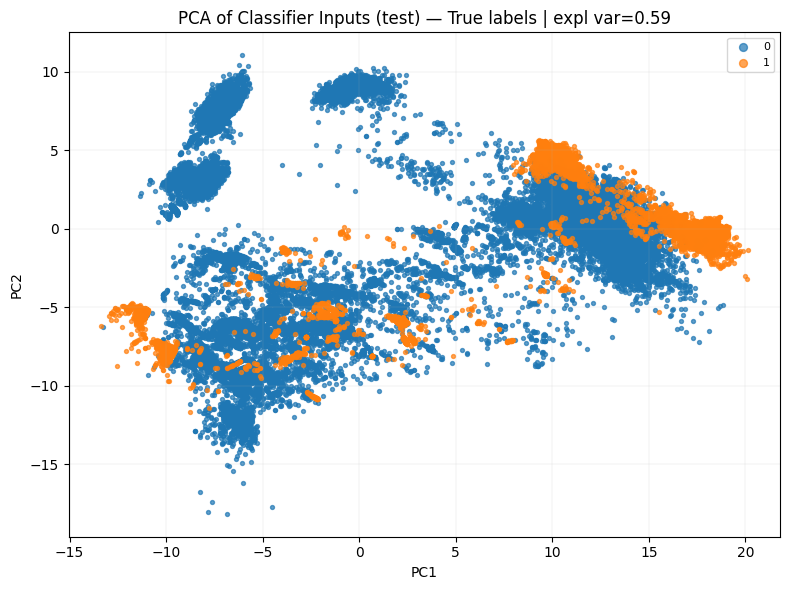

Saved: models/hybrid_snortml\pca_true_50000.png


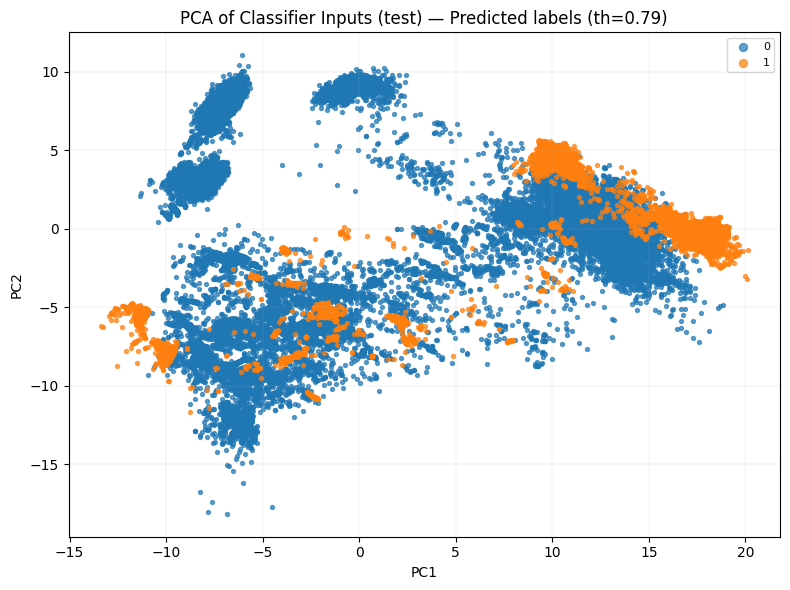

Saved: models/hybrid_snortml\pca_pred_50000.png


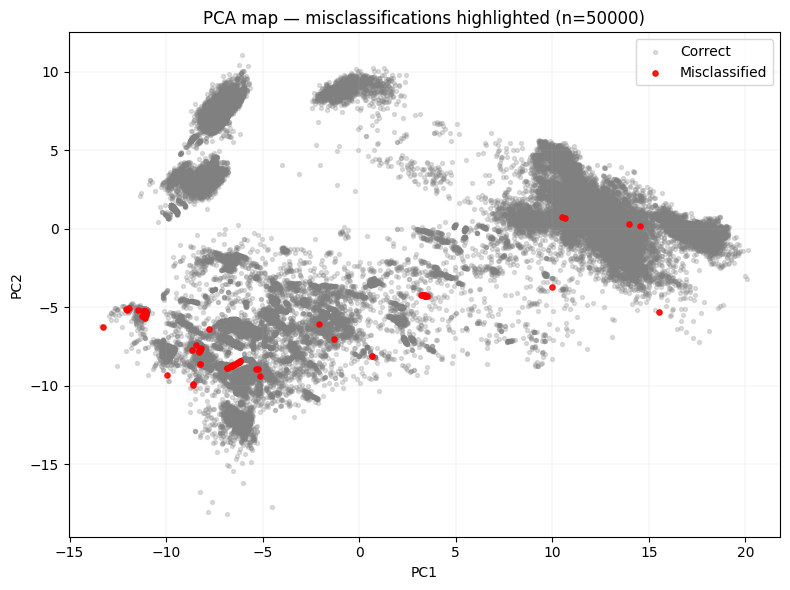

Saved: models/hybrid_snortml\pca_miscls_50000.png
Saved PCA coords CSV: models/hybrid_snortml\pca_coords_50000.csv


In [49]:
# pca_map.py
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path
import pandas as pd

# ----------------- Paths & config -----------------
MODEL_DIR = "models/hybrid_snortml"
EVAL_OUT = Path(MODEL_DIR) / "final_eval_metrics.joblib"

random_state = 42
sample_n = 50000        # subsample for plotting (None = gunakan semua)
n_components = 2        # PCA 2D untuk visualisasi
save_dir = MODEL_DIR
os.makedirs(save_dir, exist_ok=True)
# --------------------------------------------------

# --- load eval outputs if not in memory ---
if (
    'probs_te' not in globals()
    or 'yte_bin' not in globals()
    or 'best_thresh' not in globals()
):
    if EVAL_OUT.exists():
        ev = joblib.load(EVAL_OUT)
        probs_te = ev.get('probs_te', None)
        probs_val = ev.get('probs_val', None)
        yte_bin = ev.get('yte_bin', None)
        yv_bin = ev.get('yv_bin', None)
        best_thresh = ev.get('best_val_threshold', None)
        print("Loaded eval outputs from", EVAL_OUT)
    else:
        raise RuntimeError(
            "Eval outputs not in memory and final_eval_metrics.joblib not found."
        )

# Pastikan Xc_te ada (input classifier: latent + MSE test set)
if 'Xc_te' not in globals():
    raise RuntimeError("Xc_te not found in session. Prepare Xc_te (latent+MSE for test set).")

# convert & check shapes
Xc_te = np.asarray(Xc_te)
probs_te = np.asarray(probs_te).ravel()
yte_bin = np.asarray(yte_bin).astype(int).ravel()
assert Xc_te.shape[0] == probs_te.shape[0] == yte_bin.shape[0], \
    "Shape mismatch between Xc_te, probs_te, and yte_bin"

# compute predictions using best_thresh (fallback 0.5)
th = float(best_thresh) if best_thresh is not None else 0.5
y_pred = (probs_te >= th).astype(int)

# optionally subsample for speed
n_samples = Xc_te.shape[0]
if sample_n is not None and n_samples > sample_n:
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n_samples, size=sample_n, replace=False)
    X_sub = Xc_te[idx]
    y_sub = yte_bin[idx]
    preds_sub = y_pred[idx]
    probs_sub = probs_te[idx]
else:
    X_sub = Xc_te
    y_sub = yte_bin
    preds_sub = y_pred
    probs_sub = probs_te

print("PCA input samples:", X_sub.shape)

# --------------- PCA ----------------
pca = PCA(n_components=n_components, random_state=random_state)
Z = pca.fit_transform(X_sub)
explained = pca.explained_variance_ratio_.sum()
print(f"PCA explained variance ({n_components} comp): {explained:.3f}")

# helper plot
def scatter_plot(Z, labels, title, filename):
    plt.figure(figsize=(8, 6))
    unique = np.unique(labels)
    cmap_use = plt.get_cmap('tab10' if unique.shape[0] <= 10 else 'tab20')
    for i, lab in enumerate(unique):
        mask = (labels == lab)
        plt.scatter(
            Z[mask, 0], Z[mask, 1],
            s=8, alpha=0.7,
            color=cmap_use(i),
            label=str(lab)
        )
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(loc='best', fontsize=8, markerscale=2)
    plt.grid(True, linewidth=0.3, alpha=0.4)
    plt.tight_layout()
    outp = os.path.join(save_dir, filename)
    plt.savefig(outp, dpi=200)
    plt.show()
    print("Saved:", outp)

# Plot 1: true labels
scatter_plot(
    Z, y_sub,
    f"PCA of Classifier Inputs (test) — True labels | expl var={explained:.2f}",
    f"pca_true_{Z.shape[0]}.png"
)

# Plot 2: predicted labels
scatter_plot(
    Z, preds_sub,
    f"PCA of Classifier Inputs (test) — Predicted labels (th={th:.2f})",
    f"pca_pred_{Z.shape[0]}.png"
)

# Plot 3: misclassifications highlighted
correct_mask = (preds_sub == y_sub)
plt.figure(figsize=(8, 6))
plt.scatter(
    Z[correct_mask, 0], Z[correct_mask, 1],
    s=8, alpha=0.25, color='gray', label='Correct'
)
plt.scatter(
    Z[~correct_mask, 0], Z[~correct_mask, 1],
    s=14, alpha=0.9, color='red', label='Misclassified'
)
plt.title(f"PCA map — misclassifications highlighted (n={Z.shape[0]})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout()
outp = os.path.join(save_dir, f"pca_miscls_{Z.shape[0]}.png")
plt.savefig(outp, dpi=200)
plt.show()
print("Saved:", outp)

# Save koordinat + label ke CSV (opsional)
coords_df = np.column_stack([Z, y_sub, preds_sub, probs_sub])
df_out = pd.DataFrame(coords_df, columns=['pc1', 'pc2', 'y_true', 'y_pred', 'prob'])
csv_out = os.path.join(save_dir, f"pca_coords_{Z.shape[0]}.csv")
df_out.to_csv(csv_out, index=False)
print("Saved PCA coords CSV:", csv_out)


t-SNE AE input samples: (50000, 32)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.002s...


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 50000 samples in 2.002s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sample 13000 / 50000
[t-SNE] Computed conditional probabilities for sample 14000 / 50000

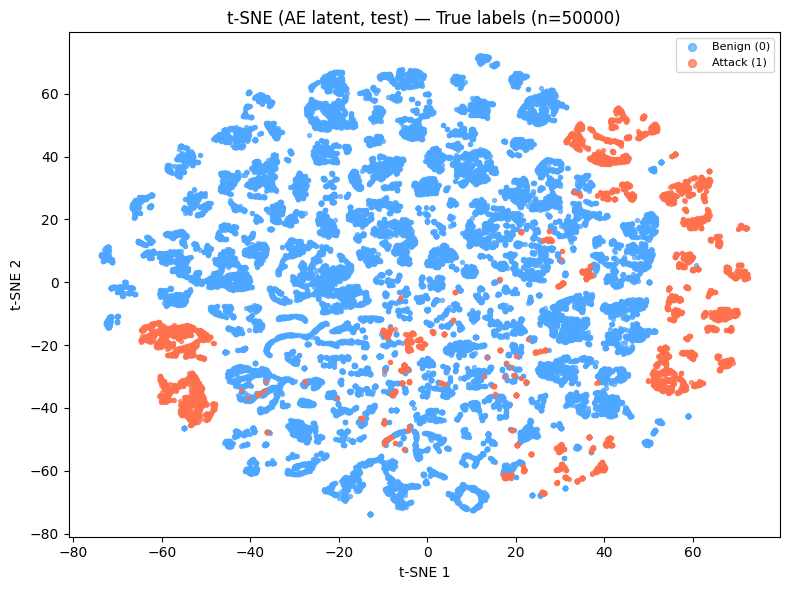

Saved: models/hybrid_snortml\tsne_ae_true_50000.png


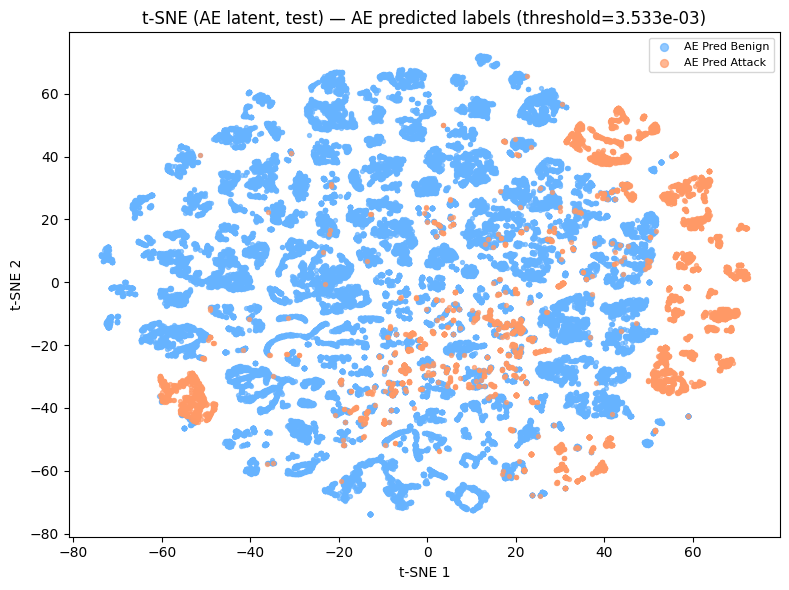

Saved: models/hybrid_snortml\tsne_ae_pred_50000.png


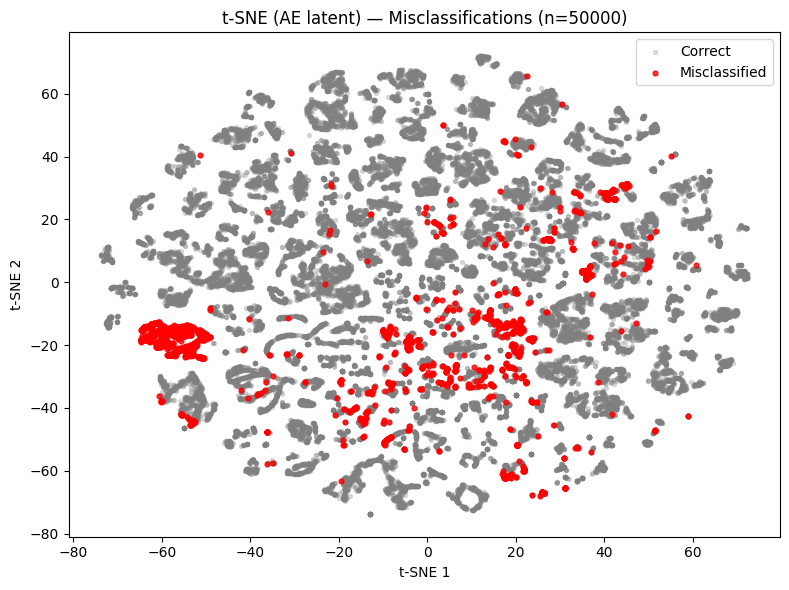

Saved: models/hybrid_snortml\tsne_ae_miscls_50000.png
Saved coords CSV: models/hybrid_snortml\tsne_ae_coords_50000.csv


In [48]:
# tsne_ae_map.py
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pathlib import Path
import pandas as pd

MODEL_DIR = "models/hybrid_snortml"
# optional: kalau kamu suatu saat mau simpan best_t / mse_te ke joblib
# bisa tambahkan path di sini
os.makedirs(MODEL_DIR, exist_ok=True)

# ---- Parameters (tweakable) ----
random_state   = 42
pca_dim_pre    = 50       # PCA pre-reduction before t-SNE (set None to skip)
tsne_dim       = 2
perplexity     = 50       # 30–50 biasanya oke untuk N besar
n_iter         = 1000     # 1000+ recommended
learning_rate  = 200.0
sample_n       = 50000    # subsample for plotting (None = use all)
save_dir       = MODEL_DIR
# --------------------------------

# ========= CEK VARIABEL AE DI SESSION =========
required_vars = ['lat_te', 'mse_te', 'yte_bin', 'best_t']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(
        "Variabel AE berikut belum ada di session: "
        + ", ".join(missing)
        + "\nPastikan kamu sudah menjalankan cell yang menghitung lat_te, mse_te, yte_bin, dan best_t."
    )

# ambil variabel AE
lat_te  = np.asarray(lat_te)
mse_te  = np.asarray(mse_te).ravel()
yte_bin = np.asarray(yte_bin).astype(int).ravel()
best_t  = float(best_t)

assert lat_te.shape[0] == mse_te.shape[0] == yte_bin.shape[0], \
    "Shape mismatch antara lat_te, mse_te, dan yte_bin"

# ---- pilih fitur yang mau di-TSNE-kan ----
# Di sini kita pakai latent AE saja (bener-bener ruang AE).
# Kalau mau, kamu bisa ganti jadi np.concatenate([lat_te, mse_te.reshape(-1,1)], axis=1)
X_ae = lat_te

# AE prediction: attack = 1 kalau MSE >= best_t
y_pred_ae = (mse_te >= best_t).astype(int)

# ========= SUBSAMPLING (BIAR GA LAMA BANGET) =========
n_samples = X_ae.shape[0]
if sample_n is not None and n_samples > sample_n:
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n_samples, size=sample_n, replace=False)
    X_sub     = X_ae[idx]
    y_sub     = yte_bin[idx]
    ypred_sub = y_pred_ae[idx]
    mse_sub   = mse_te[idx]
else:
    X_sub     = X_ae
    y_sub     = yte_bin
    ypred_sub = y_pred_ae
    mse_sub   = mse_te

print("t-SNE AE input samples:", X_sub.shape)

# ========= PCA PRE-REDUCTION (OPSIONAL TAPI DISARANKAN) =========
if pca_dim_pre is not None and pca_dim_pre < X_sub.shape[1]:
    pca = PCA(
        n_components=min(pca_dim_pre, X_sub.shape[1]),
        random_state=random_state
    )
    X_proc = pca.fit_transform(X_sub)
    print("PCA pre-reduction -> shape:", X_proc.shape)
else:
    X_proc = X_sub

# ========= RUN t-SNE DI RUANG AE =========
tsne = TSNE(
    n_components=tsne_dim,
    perplexity=perplexity,
    n_iter=n_iter,
    learning_rate=learning_rate,
    random_state=random_state,
    init='pca',
    verbose=1
)
Z = tsne.fit_transform(X_proc)
print("t-SNE (AE) done, shape:", Z.shape)

# ========= HELPER UNTUK SCATTER =========
def scatter_plot(Z, labels, title, filename, label_map=None, color_map=None):
    plt.figure(figsize=(8, 6))
    unique = np.unique(labels)
    cmap_default = plt.get_cmap('tab10' if unique.shape[0] <= 10 else 'tab20')

    for i, lab in enumerate(unique):
        mask = (labels == lab)
        # text label
        if label_map is not None and lab in label_map:
            lab_text = label_map[lab]
        else:
            lab_text = str(lab)
        # color
        if color_map is not None and lab in color_map:
            color = color_map[lab]
        else:
            color = cmap_default(i)

        plt.scatter(
            Z[mask, 0], Z[mask, 1],
            s=8, alpha=0.7,
            color=color,
            label=lab_text
        )

    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(loc='best', fontsize=8, markerscale=2)
    plt.grid(False)
    plt.tight_layout()
    outp = os.path.join(save_dir, filename)
    plt.savefig(outp, dpi=200)
    plt.show()
    print("Saved:", outp)

# ========= PLOT 1: TRUE LABELS (BENIGN VS ATTACK) =========
label_map_true = {0: "Benign (0)", 1: "Attack (1)"}
color_map_true = {0: "#4da6ff", 1: "#ff704d"}

scatter_plot(
    Z,
    y_sub,
    f"t-SNE (AE latent, test) — True labels (n={Z.shape[0]})",
    f"tsne_ae_true_{Z.shape[0]}.png",
    label_map=label_map_true,
    color_map=color_map_true
)

# ========= PLOT 2: AE PREDICTED LABELS (DARI MSE) =========
label_map_pred = {0: "AE Pred Benign", 1: "AE Pred Attack"}
color_map_pred = {0: "#66b3ff", 1: "#ff9966"}

scatter_plot(
    Z,
    ypred_sub,
    f"t-SNE (AE latent, test) — AE predicted labels (threshold={best_t:.3e})",
    f"tsne_ae_pred_{Z.shape[0]}.png",
    label_map=label_map_pred,
    color_map=color_map_pred
)

# ========= PLOT 3: MISCLASSIFICATIONS =========
correct_mask = (ypred_sub == y_sub)

plt.figure(figsize=(8, 6))
plt.scatter(
    Z[correct_mask, 0], Z[correct_mask, 1],
    s=8, alpha=0.25,
    color='gray', label='Correct'
)
plt.scatter(
    Z[~correct_mask, 0], Z[~correct_mask, 1],
    s=12, alpha=0.8,
    color='red', label='Misclassified'
)
plt.title(f"t-SNE (AE latent) — Misclassifications (n={Z.shape[0]})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
outp = os.path.join(save_dir, f"tsne_ae_miscls_{Z.shape[0]}.png")
plt.savefig(outp, dpi=200)
plt.show()
print("Saved:", outp)

# ========= OPTIONAL: SIMPAN KOORDINAT KE CSV =========
coords = np.column_stack([Z, y_sub, ypred_sub, mse_sub])
df_out = pd.DataFrame(coords, columns=['tsne1', 'tsne2', 'y_true', 'y_pred_ae', 'mse'])
csv_out = os.path.join(save_dir, f"tsne_ae_coords_{Z.shape[0]}.csv")
df_out.to_csv(csv_out, index=False)
print("Saved coords CSV:", csv_out)
